# Quantative Trading with Tesla Stock using Machine Learning Techniques
Author: Xuecheng Liu

## Introduction

The goal of this project is to predict the daily returns of Tesla stock using the daily returns of its supplier companies. We select 10 companies based on references in investopedia and we also include SPY and QQQ as an indicator for the macroeconomics.<br>
The stock prices are from Yahoo finance and we convert the price to daily returns.<br>
Each instance represent the daily returns of supplier companies in k consecutive days and concatenate in a row. We have 2357 instances in our original data from 01-01-2013 to 05-25-2022.<br>
The following cell shows the first 2 rows of the training data.<br>
The target variable is the daily returns of Tesla.We are 12k features per instance and k represent the number of days we are using per company to do the 1 step ahead prediction.

In [221]:
X_train[0:2,:]

array([[-1.12602382e-02,  4.68186069e-03,  3.52670084e-03,
        -8.23051671e-03,  6.63890681e-03,  0.00000000e+00,
         1.64318524e-02,  1.61663217e-02, -1.36363503e-02,
         8.89879420e-03,  2.09478998e-02, -1.72785664e-02,
        -6.53164296e-03,  1.17406468e-02,  4.95125124e-03,
         1.41823716e-04,  4.96263865e-03, -4.65599507e-03,
         0.00000000e+00,  7.69230879e-02, -1.51785751e-01,
         1.73952693e-02,  5.08345603e-03, -1.10345054e-02,
        -2.47253159e-02,  4.50704473e-02,  3.23449823e-02,
        -2.92449085e-03,  8.01749996e-03,  2.90937116e-03,
        -5.20825283e-03, -3.29104792e-03,  3.00310113e-04,
        -2.25931046e-03,  4.39128130e-03, -2.73246623e-03],
       [ 4.68186069e-03,  3.52670084e-03, -1.44330223e-02,
         6.63890681e-03,  0.00000000e+00,  0.00000000e+00,
         1.61663217e-02, -1.36363503e-02, -3.45630018e-03,
         2.09478998e-02, -1.72785664e-02,  0.00000000e+00,
         1.17406468e-02,  4.95125124e-03, -1.81679424e-

**Reference to the suppliers of Tesla**<br>
https://www.investopedia.com/ask/answers/052815/who-are-teslas-tsla-main-suppliers.asp <br>
https://csimarket.com/stocks/suppliers_glance.php?code=TSLA


## Data Cleaning and Preprocessing

We choose 3 days return of 10 supplier companies of TESLA and 2 Indexs to predict the next day return of TESLA in the project

First, we get data from yahoo can calculate return data and drop missing data

In [170]:
supplier_list = ['BHP','GLNCY','MOD','AA','ALB','NEE','NIOBF','AAON','REEMF','MGA','QQQ','SPY']
target_company = 'TSLA'

In [171]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import matplotlib as mlp
import matplotlib.pyplot as plt

In [172]:
def getReturn(symbol):
    data = pdr.get_data_yahoo(symbol, datetime(2013,1,1),datetime(2022,5,25))
    adjusted_price = data['Adj Close']
    daily_return = pd.DataFrame(adjusted_price.pct_change())
    daily_return.rename(columns = {'Adj Close':symbol}, inplace = True)
    return daily_return

In [173]:
daily_return = getReturn(target_company)
for supplier in supplier_list:
    new_data = getReturn(supplier)
    daily_return = daily_return.join(new_data)
data = daily_return.dropna()

In [174]:
data[0:5]

,TSLA,BHP,GLNCY,MOD,AA,ALB,NEE,NIOBF,AAON,REEMF,MGA,QQQ,SPY
Date,,,,,,,,,,,,,
2013-01-03,-0.016686,-0.011260,-0.008231,0.016432,0.008899,-0.006532,0.000142,0.000000,0.017395,-0.024725,-0.002924,-0.005208,-0.002259
2013-01-04,-0.010641,0.004682,0.006639,0.016166,0.020948,0.011741,0.004963,0.076923,0.005083,0.045070,0.008017,-0.003291,0.004391
2013-01-07,-0.001744,0.003527,0.000000,-0.013636,-0.017279,0.004951,-0.004656,-0.151786,-0.011035,0.032345,0.002909,0.000300,-0.002732
2013-01-08,-0.019220,-0.014433,0.000000,-0.003456,0.000000,-0.018168,0.010631,0.147368,0.002324,-0.041775,-0.002321,-0.001951,-0.002877
2013-01-09,-0.001188,0.005476,0.014015,0.013873,-0.002198,0.005489,-0.007013,-0.036697,0.007421,-0.032698,0.003684,0.003759,0.002542


In [175]:
def plotDailyReturn(dailyReturn,name):
    fig = plt.figure()
    ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
    ax1.plot(dailyReturn)
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Percent")
    ax1.set_title(name + " daily returns data")
    plt.show()

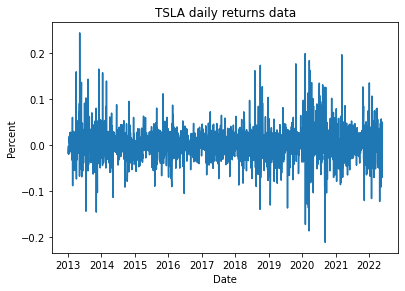

In [176]:
plotDailyReturn(data.TSLA,'TSLA')

Now we create a training set (before 2018), a validation set (Jan 2018 to Dec 2019), and a test set (the rest of the data). 

In [177]:
train_set = data[:'2018-01-01']
valid_set = data['2018-01-01':'2020-01-01']
test_set = data['2020-01-01':]

Then we choose 3 days returns of all suppliers and indexes as feartures and TSLA's next day return as the target

In [178]:
def ts_split(ts, feature_steps, target_steps):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
                  for idx in range(n_obs)])
    return X, y

In [179]:
X, y_train = ts_split(train_set["TSLA"], feature_steps = 3, target_steps = 1)

X_train, y_supplier = ts_split(train_set[supplier_list[0]], feature_steps = 3, target_steps = 1)
for supplier in supplier_list[1:]:
    X_s, y_s = ts_split(train_set[supplier], feature_steps = 3, target_steps = 1)
    X_train = np.c_[X_train, X_s]

In [180]:
X, y_valid = ts_split(valid_set["TSLA"], feature_steps = 3, target_steps = 1)

X_valid, y_supplier = ts_split(valid_set[supplier_list[0]], feature_steps = 3, target_steps = 1)
for supplier in supplier_list[1:]:
    X_s, y_s = ts_split(valid_set[supplier], feature_steps = 3, target_steps = 1)
    X_valid = np.c_[X_valid, X_s]

In [181]:
X, y_test = ts_split(test_set["TSLA"], feature_steps = 3, target_steps = 1)

X_test, y_supplier = ts_split(test_set[supplier_list[0]], feature_steps = 3, target_steps = 1)
for supplier in supplier_list[1:]:
    X_s, y_s = ts_split(test_set[supplier], feature_steps = 3, target_steps = 1)
    X_test = np.c_[X_test, X_s]

In [182]:
print(X_train.shape, X_valid.shape, X_test.shape)

(1255, 36) (500, 36) (602, 36)


In [183]:
print(y_train.shape, y_valid.shape, y_test.shape)

(1255, 1) (500, 1) (602, 1)


In [219]:
X_train[0:5,:]

array([[-1.12602382e-02,  4.68186069e-03,  3.52670084e-03,
        -8.23051671e-03,  6.63890681e-03,  0.00000000e+00,
         1.64318524e-02,  1.61663217e-02, -1.36363503e-02,
         8.89879420e-03,  2.09478998e-02, -1.72785664e-02,
        -6.53164296e-03,  1.17406468e-02,  4.95125124e-03,
         1.41823716e-04,  4.96263865e-03, -4.65599507e-03,
         0.00000000e+00,  7.69230879e-02, -1.51785751e-01,
         1.73952693e-02,  5.08345603e-03, -1.10345054e-02,
        -2.47253159e-02,  4.50704473e-02,  3.23449823e-02,
        -2.92449085e-03,  8.01749996e-03,  2.90937116e-03,
        -5.20825283e-03, -3.29104792e-03,  3.00310113e-04,
        -2.25931046e-03,  4.39128130e-03, -2.73246623e-03],
       [ 4.68186069e-03,  3.52670084e-03, -1.44330223e-02,
         6.63890681e-03,  0.00000000e+00,  0.00000000e+00,
         1.61663217e-02, -1.36363503e-02, -3.45630018e-03,
         2.09478998e-02, -1.72785664e-02,  0.00000000e+00,
         1.17406468e-02,  4.95125124e-03, -1.81679424e-

In [184]:
import random as python_random
import tensorflow as tf
import tensorflow.keras as keras

def reset_session(seed=42):
    tf.random.set_seed(seed)
    python_random.seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

## 1. Regression 

Linear Regression 

First We introduce the linear model to have an overview of this problem

In [16]:
from sklearn.linear_model import LinearRegression

reset_session()
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [17]:
from sklearn.metrics import mean_squared_error

y_pred = lin_reg.predict(X_test)
lin_mse = mean_squared_error(y_pred, y_test)

In [18]:
mse = pd.DataFrame([lin_mse], columns=["lin_mse"])
mse

,lin_mse
0,0.002271


The linear model is fast and this mse under linear model could be considered as a base value to compare

Defining the plot function to show the learning curve

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train),1000):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("MSE", fontsize=14)

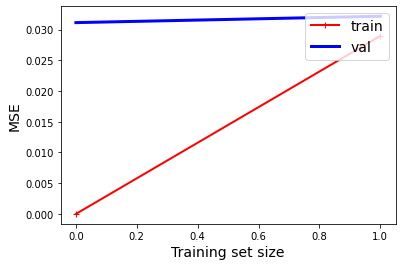

In [22]:
plot_learning_curves(lin_reg, X_train, y_train)  
plt.show()

Linear Regression using Stochastic GD 

We implement the SGDRegressor to enhance the learnear regression

In [30]:
from sklearn.linear_model import SGDRegressor

reset_session()
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train, y_train)

D:\Python\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor()

In [31]:
y_pred = sgd_reg.predict(X_test)
sgd_mse = mean_squared_error(y_pred, y_test)

In [32]:
mse["sgd_reg"] = sgd_mse
mse

,lin_mse,sgd_reg
0,0.002271,0.002189


As above shows the mse under sgd is better than the linear model

D:\Python\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Python\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


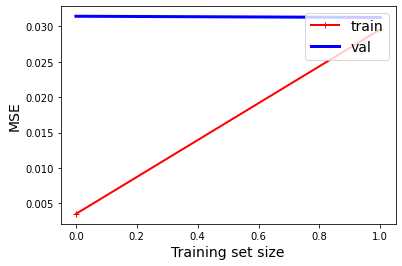

In [33]:
plot_learning_curves(sgd_reg, X_train, y_train)  
plt.show()

Polynomial Regression 

4-fold cross-validation with MSE for tuning the hyperparameters.The parameter we searched here is the optimal degree

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

reset_session()
param_distribs = {
        'degree': [2,3,4,5,6,7]
    }

poly_features = PolynomialFeatures()

rnd_search = RandomizedSearchCV(poly_features, param_distributions=param_distribs,
                                n_iter=18, cv=4, scoring='neg_mean_squared_error', random_state=42,n_jobs=-1)


poly_reg = Pipeline([
                ("rnd_search", rnd_search),
                ("lin_reg", lin_reg),])
poly_reg.fit(X_train, y_train)

D:\Python\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=18. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
D:\Python\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


Pipeline(steps=[('rnd_search',
                 RandomizedSearchCV(cv=4, estimator=PolynomialFeatures(),
                                    n_iter=18, n_jobs=-1,
                                    param_distributions={'degree': [2, 3, 4, 5,
                                                                    6, 7]},
                                    random_state=42,
                                    scoring='neg_mean_squared_error')),
                ('lin_reg', LinearRegression())])

In [35]:
rnd_search.best_params_

{'degree': 2}

The optimal degree is 2, and we check the mse under the best fit poly(degree=2)

In [36]:
poly_features = PolynomialFeatures(degree=2)
poly_reg = Pipeline([
                ("poly_features", poly_features),
                ("lin_reg", lin_reg),])
poly_reg.fit(X_train, y_train)

Pipeline(steps=[('poly_features', PolynomialFeatures()),
                ('lin_reg', LinearRegression())])

In [38]:
y_pred = poly_reg.predict(X_test)
poly_mse = mean_squared_error(y_pred, y_test)

In [39]:
mse["poly_reg"] = poly_mse
mse

,lin_mse,sgd_reg,poly_reg
0,0.002271,0.002189,0.022761


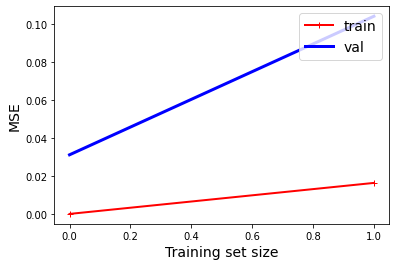

In [40]:
plot_learning_curves(poly_reg, X_train, y_train)  
plt.show()

The learning curve shows overfittinng and also the mse shows the poly model are worth than the linear and SGD model

Ridge Regression

4-fold cross-validation with MSE for tuning the hyperparameters alpha.

In [41]:
from sklearn.linear_model import Ridge

reset_session()
param_distribs = {
        'alpha': [0.01,0.1,2,5,8,1000]
    }

ridge_reg = Ridge(random_state=42)

rnd_search = RandomizedSearchCV(ridge_reg, param_distributions=param_distribs,
                                n_iter=18, cv=4, scoring='neg_mean_squared_error', random_state=42,n_jobs=-1)

rnd_search.fit(X_train, y_train)

D:\Python\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=18. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=4, estimator=Ridge(random_state=42), n_iter=18, n_jobs=-1,
                   param_distributions={'alpha': [0.01, 0.1, 2, 5, 8, 1000]},
                   random_state=42, scoring='neg_mean_squared_error')

In [42]:
rnd_search.best_params_

{'alpha': 8}

In [43]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge( alpha=8)
ridge_reg.fit(X_train, y_train)

Ridge(alpha=8)

In [44]:
y_pred = ridge_reg.predict(X_test)
ridge_mse = mean_squared_error(y_pred, y_test)

In [45]:
mse["ridge_reg"] = ridge_mse
mse

,lin_mse,sgd_reg,poly_reg,ridge_reg
0,0.002271,0.002189,0.022761,0.002191


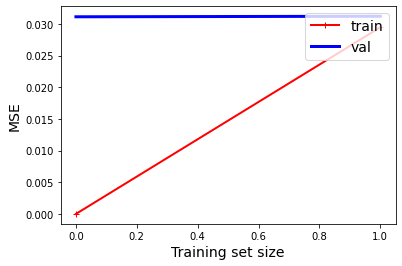

In [46]:
plot_learning_curves(ridge_reg, X_train, y_train)  
plt.show()

The learning curve shows better fit than before, and mse shows the ridge regreession is better than poly but worse than sgd

Lasso Regression 

4-fold cross-validation with MSE for tuning the hyperparameters.

In [47]:
from sklearn.linear_model import Lasso

reset_session()
param_distribs = {
         'alpha': [0.01,0.1,2,5,8,1000]
    }

lasso_reg = Lasso(random_state=42)

rnd_search = RandomizedSearchCV(lasso_reg, param_distributions=param_distribs,
                                n_iter=18, cv=4, scoring='neg_mean_squared_error', random_state=42,n_jobs=-1)

rnd_search.fit(X_train, y_train)

D:\Python\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=18. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=4, estimator=Lasso(random_state=42), n_iter=18, n_jobs=-1,
                   param_distributions={'alpha': [0.01, 0.1, 2, 5, 8, 1000]},
                   random_state=42, scoring='neg_mean_squared_error')

In [48]:
rnd_search.best_params_

{'alpha': 0.01}

In [49]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.01, random_state=42)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.01, random_state=42)

In [50]:
y_pred = lasso_reg.predict(X_test)
lasso_mse = mean_squared_error(y_pred, y_test)

In [51]:
mse["lasso_reg"] = lasso_mse
mse

,lin_mse,sgd_reg,poly_reg,ridge_reg,lasso_reg
0,0.002271,0.002189,0.022761,0.002191,0.002189


D:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


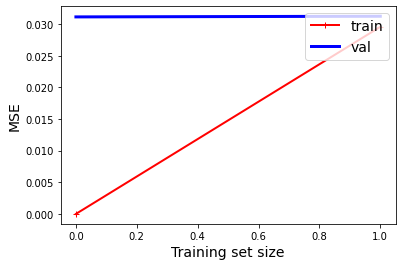

In [52]:
plot_learning_curves(lasso_reg, X_train, y_train)  
plt.show()

Lasso gets the best model than others and performs as good as sgd.

Elastic Net

4-fold cross-validation with RMSE for tuning the hyperparameters(the l1 ration and l2 ration)

In [57]:
from sklearn.linear_model import ElasticNet

reset_session()
param_distribs = {
         'alpha': [0.01,0.1,2,5,8,1000],
        'l1_ratio':np.arange(0,1,100),
        
    }

elastic_net = ElasticNet(random_state=42)

rnd_search = RandomizedSearchCV(elastic_net, param_distributions=param_distribs,
                                n_iter=18, cv=4, scoring='neg_mean_squared_error', random_state=42,n_jobs=-1)

rnd_search.fit(X_train, y_train)

D:\Python\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=18. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
D:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.586e-01, tolerance: 1.120e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


RandomizedSearchCV(cv=4, estimator=ElasticNet(random_state=42), n_iter=18,
                   n_jobs=-1,
                   param_distributions={'alpha': [0.01, 0.1, 2, 5, 8, 1000],
                                        'l1_ratio': array([0])},
                   random_state=42, scoring='neg_mean_squared_error')

In [58]:
rnd_search.best_params_

{'l1_ratio': 0, 'alpha': 0.01}

The l1 ration =0 means  the elatic net converge to LASSO and have the same optimal alpha as the optimal alpha under ridge.
This is corresponding to the results above, as LASSO regression performs better than the Ridge regression.

In [59]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.01, l1_ratio=0, random_state=42)
elastic_net.fit(X_train, y_train)

D:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.586e-01, tolerance: 1.120e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.01, l1_ratio=0, random_state=42)

In [60]:
y_pred = elastic_net.predict(X_test)
elastic_mse = mean_squared_error(y_pred, y_test)

In [61]:
mse["elastic_net"] = elastic_mse
mse

,lin_mse,sgd_reg,poly_reg,ridge_reg,lasso_reg,elastic_net
0,0.002271,0.002189,0.022761,0.002191,0.002189,0.00219


D:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
D:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.363e-01, tolerance: 8.751e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

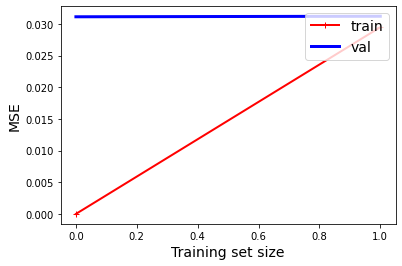

In [62]:
plot_learning_curves(elastic_net, X_train, y_train)  
plt.show()

## 2.RNN

Simple RNN

In [63]:
reset_session()

sp_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None,1])
])

sp_rnn.compile(loss="mse", optimizer="nadam")

In [64]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.01,
                                                  restore_best_weights=True)
run = sp_rnn.fit(X_train[..., np.newaxis], y_train, epochs=100,
                validation_data=(X_valid[..., np.newaxis], y_valid),
                callbacks=[early_stopping_cb], verbose=0)

From learning curve, the fit is good

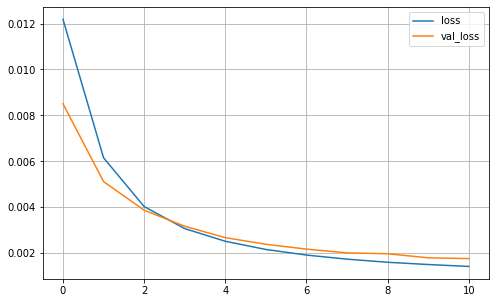

In [65]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [66]:
y_pred = sp_rnn.predict(X_test[...,np.newaxis])
sp_rnn_mse = mean_squared_error(y_pred, y_test)

19/19 [==============================] - 0s 1ms/step


Mse is much larger than linear regression in the simple rnn

In [67]:
mse["sp_rnn"] = sp_rnn_mse
mse

,lin_mse,sgd_reg,poly_reg,ridge_reg,lasso_reg,elastic_net,sp_rnn
0,0.002271,0.002189,0.022761,0.002191,0.002189,0.00219,0.014262


Deep RNN 

In [84]:
reset_session()
def build_model(n_hidden = 1, n_neurons = 20):
    model = keras.models.Sequential()
    model.add(keras.layers.SimpleRNN(n_neurons, return_sequences=True, input_shape=[None, 1]))
    for layer in range(n_hidden):
        model.add(keras.layers.SimpleRNN(n_neurons, return_sequences=True))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(1)))
    model.add(keras.layers.Lambda(lambda Y_pred: Y_pred[:, -1:]))
    model.compile(loss="mse", optimizer="nadam")
    return model

In [85]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

C:\Users\peiya\AppData\Local\Temp\ipykernel_11604\1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [86]:
keras_reg.fit(X_train[..., np.newaxis], y_train, epochs=100,
              validation_data=(X_valid[..., np.newaxis], y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
40/40 [==============================] - 1s 10ms/step - loss: 0.0128 - val_loss: 0.0027
Epoch 2/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 3/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 4/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 5/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 6/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 7/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 8/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 9/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 10/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 11

we do a random search for the number of hidden layers and the number of neurons in each layer

In [87]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(20, 80),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, n_jobs=-1)
rnd_search_cv.fit(X_train[..., np.newaxis], y_train, epochs=100,
                  validation_data=(X_valid[..., np.newaxis], y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
40/40 [==============================] - 1s 11ms/step - loss: 0.0046 - val_loss: 0.0026
Epoch 2/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 3/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 4/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 5/100
40/40 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 6/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 7/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 8/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 9/100
40/40 [==============================] - 0s 6ms/step - loss: 9.9716e-04 - val_loss: 0.0016
Epoch 10/100
40/40 [==============================] - 0s 6ms/step - loss: 9.7837e-04 - val_loss: 0.0013


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000002356F165BD0>,
                   n_jobs=-1,
                   param_distributions={'n_hidden': [1, 2, 3],
                                        'n_neurons': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79])})

the best n_neurons is 35 and n_hidden is 1

In [88]:
rnd_search_cv.best_params_

{'n_neurons': 35, 'n_hidden': 1}

In [89]:
dp_rnn =  build_model(n_hidden = 1, n_neurons = 35)

In [90]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.01,
                                                  restore_best_weights=True)
run = dp_rnn.fit(X_train[..., np.newaxis], y_train, epochs=100,
                validation_data=(X_valid[..., np.newaxis], y_valid),
                callbacks=[early_stopping_cb], verbose=0)

from learning curve, the fit is good

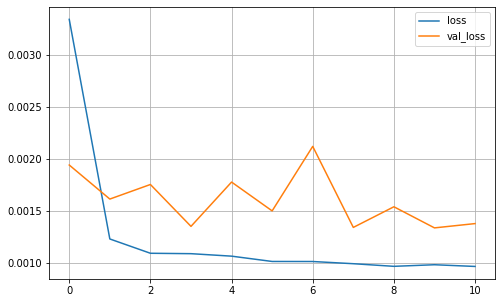

In [91]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [92]:
y_pred = dp_rnn.predict(X_test[..., np.newaxis])[...,0]
dp_rnn_mse = mean_squared_error(y_pred, y_test)

19/19 [==============================] - 0s 2ms/step


Mse is better than simple rnn but still worse than linear regression

In [93]:
mse["dp_rnn"] = dp_rnn_mse
mse

,lin_mse,sgd_reg,poly_reg,ridge_reg,lasso_reg,elastic_net,sp_rnn,dp_rnn
0,0.002271,0.002189,0.022761,0.002191,0.002189,0.00219,0.014262,0.003489


Deep RNN_Batch Normalization_Drop Out

In [94]:
reset_session()
def build_model(n_hidden = 1, n_neurons = 20, dp = 0.1):
    model = keras.models.Sequential()
    model.add(keras.layers.SimpleRNN(n_neurons, return_sequences=True, 
                                     dropout=dp, recurrent_dropout=dp,
                                     input_shape=[None, 1]))
    model.add(keras.layers.BatchNormalization())
    for layer in range(n_hidden):
        model.add(keras.layers.SimpleRNN(n_neurons,return_sequences=True, 
                                     dropout=dp, recurrent_dropout=dp))
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(1)))
    model.add(keras.layers.Lambda(lambda Y_pred: Y_pred[:, -1:]))
    model.compile(loss="mse", optimizer="nadam")
    return model

In [95]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

C:\Users\peiya\AppData\Local\Temp\ipykernel_11604\1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [96]:
keras_reg.fit(X_train[..., np.newaxis], y_train, epochs=100,
              validation_data=(X_valid[..., np.newaxis], y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
40/40 [==============================] - 3s 13ms/step - loss: 1.9721 - val_loss: 0.1172
Epoch 2/100
40/40 [==============================] - 0s 7ms/step - loss: 0.7456 - val_loss: 0.0235
Epoch 3/100
40/40 [==============================] - 0s 7ms/step - loss: 0.4492 - val_loss: 0.0285
Epoch 4/100
40/40 [==============================] - 0s 7ms/step - loss: 0.3493 - val_loss: 0.0356
Epoch 5/100
40/40 [==============================] - 0s 7ms/step - loss: 0.2631 - val_loss: 0.0611
Epoch 6/100
40/40 [==============================] - 0s 7ms/step - loss: 0.2165 - val_loss: 0.0133
Epoch 7/100
40/40 [==============================] - 0s 8ms/step - loss: 0.1616 - val_loss: 0.0062
Epoch 8/100
40/40 [==============================] - 0s 7ms/step - loss: 0.1174 - val_loss: 0.0199
Epoch 9/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0969 - val_loss: 0.0085
Epoch 10/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0850 - val_loss: 0.0328
Epoch 11

we do a random search for the number of hidden layers, the number of neurons and drop out value in each layer

In [97]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(20, 80),
    "dp":[0.01, 0.1, 1]
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, n_jobs=-1)
rnd_search_cv.fit(X_train[..., np.newaxis], y_train, epochs=100,
                  validation_data=(X_valid[..., np.newaxis], y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100


D:\Python\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Python\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Python\lib\site-packages\keras\wrappers\scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "D:\Python\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\peiya\AppData\Local\Temp\__autograph_generated

40/40 [==============================] - 3s 27ms/step - loss: 1.5152 - val_loss: 0.0816
Epoch 2/100
40/40 [==============================] - 1s 24ms/step - loss: 0.4054 - val_loss: 0.0023
Epoch 3/100
40/40 [==============================] - 1s 30ms/step - loss: 0.2116 - val_loss: 0.0258
Epoch 4/100
40/40 [==============================] - 1s 29ms/step - loss: 0.1136 - val_loss: 0.0014
Epoch 5/100
40/40 [==============================] - 1s 30ms/step - loss: 0.0574 - val_loss: 0.0015
Epoch 6/100
40/40 [==============================] - 1s 28ms/step - loss: 0.0312 - val_loss: 0.0013
Epoch 7/100
40/40 [==============================] - 1s 28ms/step - loss: 0.0202 - val_loss: 0.0017
Epoch 8/100
40/40 [==============================] - 1s 28ms/step - loss: 0.0280 - val_loss: 0.0018
Epoch 9/100
40/40 [==============================] - 1s 30ms/step - loss: 0.0179 - val_loss: 0.0018
Epoch 10/100
40/40 [==============================] - 1s 25ms/step - loss: 0.0131 - val_loss: 0.0012
Epoch 11/10

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x0000023574D47FD0>,
                   n_jobs=-1,
                   param_distributions={'dp': [0.01, 0.1, 1],
                                        'n_hidden': [1, 2, 3],
                                        'n_neurons': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79])})

the best n_neurons is 77, n_hidden is 2 and dp is 0.1

In [98]:
rnd_search_cv.best_params_

{'n_neurons': 77, 'n_hidden': 2, 'dp': 0.1}

In [101]:
dr_bn_do = build_model(n_hidden = 2, n_neurons = 77, dp = 0.01)

In [102]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.01,
                                                  restore_best_weights=True)
run = dr_bn_do.fit(X_train[..., np.newaxis], y_train, epochs=100,
                validation_data=(X_valid[..., np.newaxis], y_valid),
                callbacks=[early_stopping_cb], verbose=0)

From learning curve, the fit is good

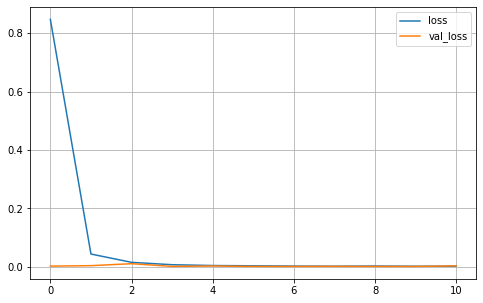

In [103]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [104]:
y_pred = dr_bn_do.predict(X_test[...,np.newaxis])[...,0]
dr_bn_do_mse = mean_squared_error(y_pred, y_test, multioutput="raw_values")

19/19 [==============================] - 0s 3ms/step


Mse is better than deep rnn but still worse than linear regression

In [105]:
mse["deepRNN-BN-DO"] = dr_bn_do_mse
mse

,lin_mse,sgd_reg,poly_reg,ridge_reg,lasso_reg,elastic_net,sp_rnn,dp_rnn,deepRNN-BN-DO
0,0.002271,0.002189,0.022761,0.002191,0.002189,0.00219,0.014262,0.003489,0.00342


DeepRNN_dense_each

Recreate the X and y variables

In [106]:
X_tsla, y = ts_split(data["TSLA"], feature_steps = 3, target_steps = 1)

X, y_supplier = ts_split(data[supplier_list[0]], feature_steps = 3, target_steps = 1)
for supplier in supplier_list[1:]:
    X_s, y_s = ts_split(data[supplier], feature_steps = 3, target_steps = 1)
    X = np.c_[X, X_s]

In [107]:
print(X.shape, y.shape)

(2363, 36) (2363, 1)


we have 3 steps, like [ [supplier1_day1, ... , supplier12_day1], [supplier1_day2, ... , supplier12_day2],  [supplier1_day3, ... , supplier12_day3]] of features for 1 step ahead prediction

In [108]:
X_de = []
for x in X:
    X_de.append([[x[0+i],x[3+i],x[6+i],x[9+i],x[12+i],
                 x[15+i],x[18+i],x[21+i],x[24+i],x[27+i],x[30+i],x[33+i]] for i in range(0,3)])

In [114]:
X_de = np.array(X_de)
X_de.shape

(2363, 3, 12)

In [118]:
n_steps = 3
n_ahead = 1
n_sample = X_de.shape[0]
series = np.concatenate((X, y), axis=1)[...,np.newaxis]
train_idx = len(X_train)
valid_idx = len(X_train) + len(X_valid)

X_train_de = series[:train_idx, :n_steps]
X_valid_de = series[train_idx:valid_idx, :n_steps]
X_test_de = series[valid_idx:, :n_steps]
Y = np.empty((n_sample, n_steps, n_ahead))
for step_ahead in range(1, n_ahead + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
y_train_de = Y[:train_idx]
y_valid_de = Y[train_idx:valid_idx]
y_test_de = Y[valid_idx:]

In [119]:
print(X_train_de.shape, y_train_de.shape)

(1255, 3, 1) (1255, 3, 1)


In [120]:
reset_session()
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

def build_model(n_hidden = 1, n_neurons = 20):
    model = keras.models.Sequential()
    model.add(keras.layers.SimpleRNN(n_neurons, return_sequences=True, 
                                     input_shape=[None, 1]))
    for layer in range(n_hidden):
        model.add(keras.layers.SimpleRNN(n_neurons,return_sequences=True))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(1)))
    model.compile(loss="mse", optimizer="nadam",metrics=[last_time_step_mse])
    return model

In [121]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

C:\Users\peiya\AppData\Local\Temp\ipykernel_11604\1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [122]:
keras_reg.fit(X_train_de, y_train_de, epochs=100,
              validation_data=(X_valid_de, y_valid_de),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
40/40 [==============================] - 2s 7ms/step - loss: 4.7676e-04 - last_time_step_mse: 5.5110e-04 - val_loss: 2.5351e-04 - val_last_time_step_mse: 2.4771e-04
Epoch 2/100
40/40 [==============================] - 0s 2ms/step - loss: 4.4149e-04 - last_time_step_mse: 5.0182e-04 - val_loss: 3.6309e-04 - val_last_time_step_mse: 5.4713e-04
Epoch 3/100
40/40 [==============================] - 0s 2ms/step - loss: 4.5314e-04 - last_time_step_mse: 5.1455e-04 - val_loss: 2.4322e-04 - val_last_time_step_mse: 2.2818e-04
Epoch 4/100
40/40 [==============================] - 0s 2ms/step - loss: 4.3347e-04 - last_time_step_mse: 4.8235e-04 - val_loss: 2.5072e-04 - val_last_time_step_mse: 2.4232e-04
Epoch 5/100
40/40 [==============================] - 0s 2ms/step - loss: 4.4064e-04 - last_time_step_mse: 4.9404e-04 - val_loss: 2.8969e-04 - val_last_time_step_mse: 2.2574e-04
Epoch 6/100
40/40 [==============================] - 0s 2ms/step - loss: 4.4353e-04 - last_time_step_mse: 4.9100e-0

we do a random search for the number of hidden layers and the number of neurons in each layer

In [124]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(20, 80)
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, n_jobs=-1)
rnd_search_cv.fit(X_train_de, y_train_de, epochs=10,
                  validation_data=(X_valid_de, y_valid_de),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/10
40/40 [==============================] - 2s 7ms/step - loss: 5.3589e-04 - last_time_step_mse: 6.8039e-04 - val_loss: 2.8672e-04 - val_last_time_step_mse: 3.2892e-04
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 4.5405e-04 - last_time_step_mse: 5.2570e-04 - val_loss: 4.3174e-04 - val_last_time_step_mse: 7.3561e-04
Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 4.7180e-04 - last_time_step_mse: 5.5453e-04 - val_loss: 2.4647e-04 - val_last_time_step_mse: 2.3490e-04
Epoch 4/10
40/40 [==============================] - 0s 2ms/step - loss: 4.3769e-04 - last_time_step_mse: 4.8943e-04 - val_loss: 2.5325e-04 - val_last_time_step_mse: 2.4312e-04
Epoch 5/10
40/40 [==============================] - 0s 2ms/step - loss: 4.4332e-04 - last_time_step_mse: 4.9517e-04 - val_loss: 3.1437e-04 - val_last_time_step_mse: 2.4297e-04
Epoch 6/10
40/40 [==============================] - 0s 2ms/step - loss: 4.5052e-04 - last_time_step_mse: 4.9848e-04 - va

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000002350101FA30>,
                   n_jobs=-1,
                   param_distributions={'n_hidden': [1, 2, 3],
                                        'n_neurons': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79])})

the best n_neurons is 73 and n_hidden is 2

In [125]:
rnd_search_cv.best_params_

{'n_neurons': 73, 'n_hidden': 2}

In [126]:
dr_de = build_model(n_hidden = 2, n_neurons = 73)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.01,
                                                  restore_best_weights=True, 
                                                  monitor="val_last_time_step_mse", 
                                                  mode="min")
run = dr_de.fit(X_train_de, y_train_de, epochs=100,
                    validation_data=(X_valid_de, y_valid_de),
                    callbacks=[early_stopping_cb], verbose=0)

From learning curve, it's good

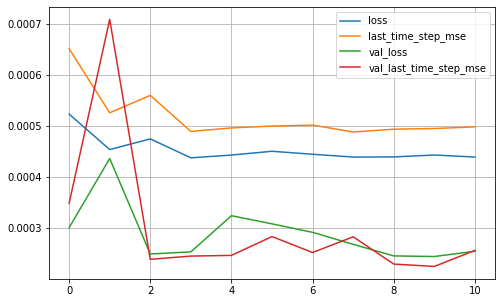

In [127]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [128]:
y_pred = dr_de.predict(X_test_de)
dr_de_mse = mean_squared_error(y_pred[:, -1], y_test_de[:, -1], multioutput="raw_values")

19/19 [==============================] - 0s 1ms/step


mse is much better than regression

In [129]:
mse["deepRNN_dense_each"] = dr_de_mse
mse

,lin_mse,sgd_reg,poly_reg,ridge_reg,lasso_reg,elastic_net,sp_rnn,dp_rnn,deepRNN-BN-DO,deepRNN_dense_each
0,0.002271,0.002189,0.022761,0.002191,0.002189,0.00219,0.014262,0.003489,0.00342,0.00047


 Long Short Term Memory (LSTM)

In [130]:
reset_session()
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

def build_model(n_hidden = 1, n_neurons = 20):
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(n_neurons, return_sequences=True, 
                                     input_shape=[None, 1]))
    for layer in range(n_hidden):
        model.add(keras.layers.LSTM(n_neurons,return_sequences=True))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(1)))
    model.compile(loss="mse", optimizer="nadam",metrics=[last_time_step_mse])
    return model

In [131]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

C:\Users\peiya\AppData\Local\Temp\ipykernel_11604\1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [132]:
keras_reg.fit(X_train_de, y_train_de, epochs=100,
              validation_data=(X_valid_de, y_valid_de),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
40/40 [==============================] - 3s 16ms/step - loss: 5.7733e-04 - last_time_step_mse: 9.1759e-04 - val_loss: 3.2600e-04 - val_last_time_step_mse: 4.5455e-04
Epoch 2/100
40/40 [==============================] - 0s 4ms/step - loss: 5.5002e-04 - last_time_step_mse: 8.3682e-04 - val_loss: 2.9740e-04 - val_last_time_step_mse: 3.7802e-04
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 5.1725e-04 - last_time_step_mse: 7.0577e-04 - val_loss: 2.8859e-04 - val_last_time_step_mse: 3.2669e-04
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 4.8927e-04 - last_time_step_mse: 6.1410e-04 - val_loss: 2.8749e-04 - val_last_time_step_mse: 3.1575e-04
Epoch 5/100
40/40 [==============================] - 0s 2ms/step - loss: 4.9138e-04 - last_time_step_mse: 6.1552e-04 - val_loss: 2.6954e-04 - val_last_time_step_mse: 2.7507e-04
Epoch 6/100
40/40 [==============================] - 0s 3ms/step - loss: 4.7513e-04 - last_time_step_mse: 5.7674e-

we do a random search for the number of hidden layers and the number of neurons in each layer



In [133]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(20, 80)
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, n_jobs=-1)
rnd_search_cv.fit(X_train_de, y_train_de, epochs=100,
                  validation_data=(X_valid_de, y_valid_de),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
40/40 [==============================] - 4s 20ms/step - loss: 5.7738e-04 - last_time_step_mse: 9.1322e-04 - val_loss: 3.2556e-04 - val_last_time_step_mse: 4.4826e-04
Epoch 2/100
40/40 [==============================] - 0s 4ms/step - loss: 5.3755e-04 - last_time_step_mse: 7.8225e-04 - val_loss: 4.0151e-04 - val_last_time_step_mse: 6.0283e-04
Epoch 3/100
40/40 [==============================] - 0s 5ms/step - loss: 4.9745e-04 - last_time_step_mse: 6.4416e-04 - val_loss: 2.7457e-04 - val_last_time_step_mse: 2.9032e-04
Epoch 4/100
40/40 [==============================] - 0s 4ms/step - loss: 4.7380e-04 - last_time_step_mse: 5.7329e-04 - val_loss: 2.8077e-04 - val_last_time_step_mse: 3.0185e-04
Epoch 5/100
40/40 [==============================] - 0s 4ms/step - loss: 4.8166e-04 - last_time_step_mse: 5.9352e-04 - val_loss: 2.6146e-04 - val_last_time_step_mse: 2.5885e-04
Epoch 6/100
40/40 [==============================] - 0s 4ms/step - loss: 4.6537e-04 - last_time_step_mse: 5.5425e-

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x0000023508417EB0>,
                   n_jobs=-1,
                   param_distributions={'n_hidden': [1, 2, 3],
                                        'n_neurons': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79])})

the best n_neurons is 38 and n_hidden is 2

In [135]:
rnd_search_cv.best_params_

{'n_neurons': 38, 'n_hidden': 2}

In [136]:
lstm = build_model(n_hidden = 2, n_neurons = 38)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.01,
                                                  restore_best_weights=True)
run = lstm.fit(X_train_de, y_train_de, epochs=200,
                    validation_data=(X_valid_de, y_valid_de),
                    callbacks=[early_stopping_cb], verbose=0)

From learning curve, it's good

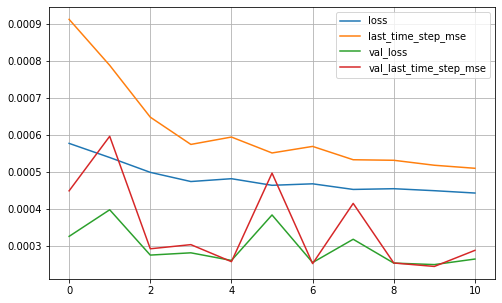

In [137]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [138]:
y_pred = lstm.predict(X_test_de)
lstm_mse = mean_squared_error(y_pred[:, -1], y_test_de[:, -1], multioutput="raw_values")

19/19 [==============================] - 1s 2ms/step


mse is a bit worse than deepRNN_dense_each, but is much better than others

In [139]:
mse["deepLSTM_dense_each"] = lstm_mse
mse

,lin_mse,sgd_reg,poly_reg,ridge_reg,lasso_reg,elastic_net,sp_rnn,dp_rnn,deepRNN-BN-DO,deepRNN_dense_each,deepLSTM_dense_each
0,0.002271,0.002189,0.022761,0.002191,0.002189,0.00219,0.014262,0.003489,0.00342,0.00047,0.00086


## 3.MLP

We first build a simple mlp with 1 hidden layer as a baseline model.

In [185]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(36,)),
    keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(1, activation="relu", kernel_initializer="he_normal")
])

optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=["mse"])

run = model.fit(X_train, y_train, epochs=30,
          validation_data=(X_valid, y_valid), verbose=0)

We check the whether the model is overfitting as usual

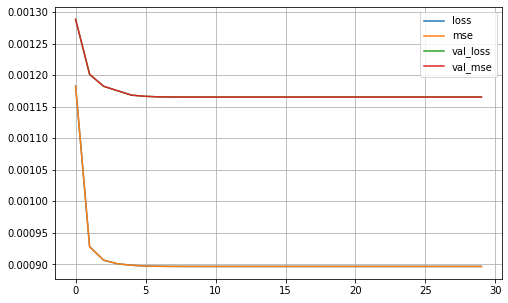

In [186]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

Even such a simple mlp we seem to overfit the data

In [187]:
y_test_pred = model.predict(X_test)
mse["simple mlp"] = mean_squared_error(y_test, y_test_pred)
mse

19/19 [==============================] - 0s 606us/step


,lin_mse,sgd_reg,poly_reg,ridge_reg,lasso_reg,elastic_net,sp_rnn,dp_rnn,deepRNN-BN-DO,deepRNN_dense_each,deepLSTM_dense_each,simple mlp,deep mlp,simple CNN,deep CNN,deep CNN ave,deep CNN max
0,0.002271,0.002189,0.022761,0.002191,0.002189,0.00219,0.014262,0.003489,0.00342,0.00047,0.00086,0.002178,0.002789,0.002312,0.006322,0.006089,0.002678


Next we perform hyper parameter tuning using a randomized search to search for the best number of hidden layers, neurons per hidden layer.

In [188]:
def build_model(n_hidden=1, n_neurons=30):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(36,)))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="selu", kernel_initializer="lecun_normal"))
    model.add(keras.layers.Dense(1, kernel_initializer="glorot_uniform"))
    model.compile(loss="mse", optimizer='nadam')
    return model

In [189]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

C:\Users\peiya\AppData\Local\Temp\ipykernel_11604\1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [190]:
reset_session()
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [2,3,4,5],
    "n_neurons": np.arange(50,100).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=0)
rnd_search_cv.fit(X_train, y_train, epochs=30,
                  validation_data=(X_valid, y_valid), verbose=0,
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

14/14 [==============================] - 0s 1ms/step - loss: 9.3119e-04


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000002359A55C610>,
                   param_distributions={'n_hidden': [2, 3, 4, 5],
                                        'n_neurons': [50, 51, 52, 53, 54, 55,
                                                      56, 57, 58, 59, 60, 61,
                                                      62, 63, 64, 65, 66, 67,
                                                      68, 69, 70, 71, 72, 73,
                                                      74, 75, 76, 77, 78, 79, ...]})

In [194]:
nLayer = rnd_search_cv.best_params_['n_hidden']
nNeuron = rnd_search_cv.best_params_['n_neurons']

Now we build the deep mlp with the hyper parameters found above

In [195]:
dmlp = build_model(n_hidden =nLayer, n_neurons = nNeuron)

run = dmlp.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)], verbose=0)

We check if we are overfitting the data

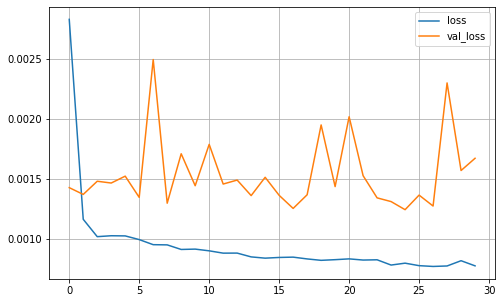

In [196]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [197]:
y_test_pre = dmlp.predict(X_test)
mse["deep mlp"] = mean_squared_error(y_test, y_test_pre)
mse

19/19 [==============================] - 0s 554us/step


,lin_mse,sgd_reg,poly_reg,ridge_reg,lasso_reg,elastic_net,sp_rnn,dp_rnn,deepRNN-BN-DO,deepRNN_dense_each,deepLSTM_dense_each,simple mlp,deep mlp,simple CNN,deep CNN,deep CNN ave,deep CNN max
0,0.002271,0.002189,0.022761,0.002191,0.002189,0.00219,0.014262,0.003489,0.00342,0.00047,0.00086,0.002178,0.002666,0.002312,0.006322,0.006089,0.002678


The mse of deep mlp is worse than simple mlp and adding extra layers does not help.

## 4.CNN

In [198]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import AveragePooling1D
from sklearn.metrics import mean_squared_error

**In order to feed the data into CNN, we need to add 1 extra dimension to our original data**

In [199]:
def reshape3D(data,feature):
    return data.reshape(data.shape[0],data.shape[1],feature)

feature = 1
X_train_3D = reshape3D(X_train,feature)
X_valid_3D = reshape3D(X_valid,feature)
X_test_3D = reshape3D(X_test,feature)

**We first set up an simple CNN architecture with 1 convolution layer, 1 pooling layer and 1 dense layer as our baseline model**

In [200]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=(36,
feature)))
model.add(AveragePooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(100, activation='selu',kernel_initializer="lecun_normal"))
model.add(Dense(1))
model.compile(optimizer='nadam', loss='mse',)

In [201]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('CNN',save_best_only=True)
run = model.fit(X_train_3D,y_train,epochs = 30, validation_data=(X_valid_3D,y_valid),callbacks=[checkpoint_cb,])

Epoch 1/30
36/40 [==========================>...] - ETA: 0s - loss: 9.8005e-04 

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 13ms/step - loss: 9.6755e-04 - val_loss: 0.0012
Epoch 2/30
40/40 [==============================] - 0s 2ms/step - loss: 9.3370e-04 - val_loss: 0.0012
Epoch 3/30
40/40 [==============================] - 0s 2ms/step - loss: 8.9341e-04 - val_loss: 0.0014
Epoch 4/30
40/40 [==============================] - 0s 2ms/step - loss: 8.9873e-04 - val_loss: 0.0012
Epoch 5/30
40/40 [==============================] - 0s 2ms/step - loss: 8.8999e-04 - val_loss: 0.0015
Epoch 6/30
40/40 [==============================] - 0s 2ms/step - loss: 8.9557e-04 - val_loss: 0.0012
Epoch 7/30
40/40 [==============================] - 0s 2ms/step - loss: 8.6924e-04 - val_loss: 0.0021
Epoch 8/30
40/40 [==============================] - 0s 2ms/step - loss: 8.7930e-04 - val_loss: 0.0012
Epoch 9/30
40/40 [==============================] - 0s 3ms/step - loss: 8.6190e-04 - val_loss: 0.0014
Epoch 10/30
40/40 [==============================] - 0s 2ms/step - loss: 8.6448e-04 - val_lo

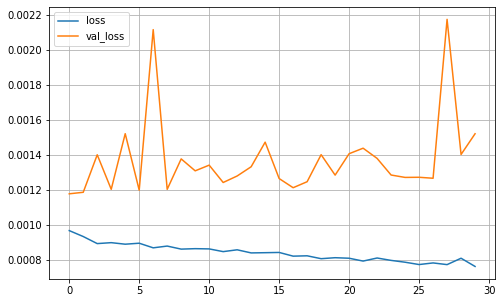

In [202]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

**From the figure above, we could tell that there is a bit overfitting because of the gap**

**Compute MSE and append it to MSE dataframe for comparison**

In [203]:
CNN_best = keras.models.load_model('CNN')
y_test_predict = CNN_best.predict(X_test_3D,verbose = 0)
mse["simple CNN"] = mean_squared_error(y_test, y_test_predict)
mse

,lin_mse,sgd_reg,poly_reg,ridge_reg,lasso_reg,elastic_net,sp_rnn,dp_rnn,deepRNN-BN-DO,deepRNN_dense_each,deepLSTM_dense_each,simple mlp,deep mlp,simple CNN,deep CNN,deep CNN ave,deep CNN max
0,0.002271,0.002189,0.022761,0.002191,0.002189,0.00219,0.014262,0.003489,0.00342,0.00047,0.00086,0.002178,0.002666,0.002267,0.006322,0.006089,0.002678


**Next we want to experiment with whether adding convolution layer and pooling layer helps in a deep CNN**


**Since there are too many combinations of hyper parameter to tune in deep CNN after introducing the convolution layer and pooling layer, I would like to start with the best deep mlp I got in previous sections, fixing the convolution layer and varying the type of pooling layer as well as the pooling size to do a simlified experiment.**

**We first experiment over max pooling**

In [204]:
def buildModelMaxPool(size):
    model = keras.models.Sequential()
    model.add(keras.layers.BatchNormalization())
    model.add(Conv1D(filters=10, kernel_size=3, activation='relu', input_shape=(36,feature)))
    model.add(MaxPooling1D(pool_size=size))
    model.add(Flatten())
    for layer in range(nLayer):
        model.add(keras.layers.Dense(nNeuron,activation = 'selu',kernel_initializer="lecun_normal"))
    model.add(keras.layers.Dense(1, kernel_initializer="glorot_uniform"))
    model.compile(loss="mse", optimizer='nadam')
    return model

In [205]:
max_pool_mse = []
max_pool_size = [2,3,4,5,6,7,8,9,10]
for size in max_pool_size:
    checkpoint_cb = keras.callbacks.ModelCheckpoint('CNN',save_best_only=True)
    run = model.fit(X_train_3D,y_train,epochs = 30, validation_data=(X_valid_3D,y_valid),callbacks=[checkpoint_cb,])
    CNN_best = keras.models.load_model('CNN')
    y_test_predict = CNN_best.predict(X_test_3D,verbose = 0)
    max_pool_mse.append(mean_squared_error(y_test, y_test_predict))

Epoch 1/30
29/40 [====================>.........] - ETA: 0s - loss: 7.6490e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 7.5187e-04 - val_loss: 0.0014
Epoch 2/30
38/40 [===========================>..] - ETA: 0s - loss: 7.6532e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 7.6240e-04 - val_loss: 0.0013
Epoch 3/30
40/40 [==============================] - 0s 3ms/step - loss: 7.3592e-04 - val_loss: 0.0019
Epoch 4/30
40/40 [==============================] - 0s 2ms/step - loss: 7.7033e-04 - val_loss: 0.0014
Epoch 5/30
40/40 [==============================] - 0s 2ms/step - loss: 7.3296e-04 - val_loss: 0.0017
Epoch 6/30
40/40 [==============================] - 0s 2ms/step - loss: 7.3583e-04 - val_loss: 0.0014
Epoch 7/30
40/40 [==============================] - 0s 3ms/step - loss: 7.2120e-04 - val_loss: 0.0026
Epoch 8/30
40/40 [==============================] - 0s 3ms/step - loss: 7.5079e-04 - val_loss: 0.0014
Epoch 9/30
40/40 [==============================] - 0s 2ms/step - loss: 7.0841e-04 - val_loss: 0.0015
Epoch 10/30
40/40 [==============================] - 0s 2ms/step - loss: 7.1438e-04 - val_loss: 0.0014
Epoch 11/30
40/40 [==============================] - 0s 2ms/step - loss: 7.1611e-04 - val_l

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 6.2027e-04 - val_loss: 0.0016
Epoch 2/30
34/40 [========================>.....] - ETA: 0s - loss: 6.6405e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 12ms/step - loss: 6.3032e-04 - val_loss: 0.0015
Epoch 3/30
40/40 [==============================] - 0s 2ms/step - loss: 5.9933e-04 - val_loss: 0.0019
Epoch 4/30
40/40 [==============================] - 0s 2ms/step - loss: 6.3116e-04 - val_loss: 0.0017
Epoch 5/30
40/40 [==============================] - 0s 3ms/step - loss: 6.0134e-04 - val_loss: 0.0017
Epoch 6/30
40/40 [==============================] - 0s 3ms/step - loss: 5.9653e-04 - val_loss: 0.0015
Epoch 7/30
40/40 [==============================] - 0s 2ms/step - loss: 5.9327e-04 - val_loss: 0.0023
Epoch 8/30
40/40 [==============================] - 0s 2ms/step - loss: 6.2109e-04 - val_loss: 0.0016
Epoch 9/30
40/40 [==============================] - 0s 3ms/step - loss: 5.8184e-04 - val_loss: 0.0017
Epoch 10/30
40/40 [==============================] - 0s 3ms/step - loss: 5.7777e-04 - val_loss: 0.0016
Epoch 11/30
40/40 [==============================] - 0s 3ms/step - loss: 5.8115e-04 - val_l

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 5.2154e-04 - val_loss: 0.0019
Epoch 2/30
39/40 [============================>.] - ETA: 0s - loss: 5.2611e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 5.2429e-04 - val_loss: 0.0017
Epoch 3/30
40/40 [==============================] - 0s 2ms/step - loss: 4.8668e-04 - val_loss: 0.0021
Epoch 4/30
40/40 [==============================] - 0s 2ms/step - loss: 5.3875e-04 - val_loss: 0.0018
Epoch 5/30
40/40 [==============================] - 0s 2ms/step - loss: 4.9348e-04 - val_loss: 0.0020
Epoch 6/30
40/40 [==============================] - 0s 2ms/step - loss: 4.8463e-04 - val_loss: 0.0017
Epoch 7/30
40/40 [==============================] - 0s 2ms/step - loss: 4.8972e-04 - val_loss: 0.0019
Epoch 8/30
40/40 [==============================] - 0s 3ms/step - loss: 5.0293e-04 - val_loss: 0.0017
Epoch 9/30
40/40 [==============================] - 0s 2ms/step - loss: 4.7879e-04 - val_loss: 0.0018
Epoch 10/30
40/40 [==============================] - 0s 3ms/step - loss: 4.7192e-04 - val_loss: 0.0018
Epoch 11/30
40/40 [==============================] - 0s 3ms/step - loss: 4.8119e-04 - val_l

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 14ms/step - loss: 4.9853e-04 - val_loss: 0.0017
Epoch 17/30
40/40 [==============================] - 0s 2ms/step - loss: 4.4507e-04 - val_loss: 0.0018
Epoch 18/30
40/40 [==============================] - 0s 2ms/step - loss: 4.9023e-04 - val_loss: 0.0019
Epoch 19/30
40/40 [==============================] - 0s 2ms/step - loss: 4.9188e-04 - val_loss: 0.0017
Epoch 20/30
40/40 [==============================] - 0s 2ms/step - loss: 4.6824e-04 - val_loss: 0.0020
Epoch 21/30
40/40 [==============================] - 0s 3ms/step - loss: 4.4527e-04 - val_loss: 0.0022
Epoch 22/30
40/40 [==============================] - 0s 2ms/step - loss: 4.6433e-04 - val_loss: 0.0018
Epoch 23/30
40/40 [==============================] - 0s 2ms/step - loss: 4.3797e-04 - val_loss: 0.0023
Epoch 24/30
40/40 [==============================] - 0s 2ms/step - loss: 4.5304e-04 - val_loss: 0.0019
Epoch 25/30
40/40 [==============================] - 0s 2ms/step - loss: 4.1889e-04 

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 14ms/step - loss: 4.4415e-04 - val_loss: 0.0022
Epoch 2/30
39/40 [============================>.] - ETA: 0s - loss: 4.3582e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 13ms/step - loss: 4.3418e-04 - val_loss: 0.0019
Epoch 3/30
40/40 [==============================] - 0s 2ms/step - loss: 4.0490e-04 - val_loss: 0.0023
Epoch 4/30
40/40 [==============================] - 0s 2ms/step - loss: 4.7909e-04 - val_loss: 0.0020
Epoch 5/30
40/40 [==============================] - 0s 2ms/step - loss: 4.1303e-04 - val_loss: 0.0022
Epoch 6/30
40/40 [==============================] - 0s 2ms/step - loss: 4.1058e-04 - val_loss: 0.0019
Epoch 7/30
40/40 [==============================] - 0s 2ms/step - loss: 4.2533e-04 - val_loss: 0.0024
Epoch 8/30
40/40 [==============================] - 0s 2ms/step - loss: 4.5840e-04 - val_loss: 0.0019
Epoch 9/30
40/40 [==============================] - 0s 2ms/step - loss: 4.1885e-04 - val_loss: 0.0021
Epoch 10/30
40/40 [==============================] - 0s 2ms/step - loss: 4.0272e-04 - val_loss: 0.0020
Epoch 11/30
40/40 [==============================] - 0s 2ms/step - loss: 4.0613e-04 - val_l

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 4.2624e-04 - val_loss: 0.0019
Epoch 17/30
40/40 [==============================] - 0s 2ms/step - loss: 3.8242e-04 - val_loss: 0.0020
Epoch 18/30
40/40 [==============================] - 0s 2ms/step - loss: 4.2390e-04 - val_loss: 0.0021
Epoch 19/30
39/40 [============================>.] - ETA: 0s - loss: 4.3174e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 4.3072e-04 - val_loss: 0.0019
Epoch 20/30
40/40 [==============================] - 0s 2ms/step - loss: 4.2577e-04 - val_loss: 0.0021
Epoch 21/30
40/40 [==============================] - 0s 2ms/step - loss: 3.8333e-04 - val_loss: 0.0024
Epoch 22/30
40/40 [==============================] - 0s 2ms/step - loss: 3.9596e-04 - val_loss: 0.0020
Epoch 23/30
40/40 [==============================] - 0s 2ms/step - loss: 3.7026e-04 - val_loss: 0.0026
Epoch 24/30
40/40 [==============================] - 0s 2ms/step - loss: 3.9493e-04 - val_loss: 0.0021
Epoch 25/30
40/40 [==============================] - 0s 2ms/step - loss: 3.6150e-04 - val_loss: 0.0022
Epoch 26/30
40/40 [==============================] - 0s 2ms/step - loss: 3.7282e-04 - val_loss: 0.0024
Epoch 27/30
40/40 [==============================] - 0s 2ms/step - loss: 3.7717e-04 - val_loss: 0.0022
Epoch 28/30
40/40 [==============================] - 0s 2ms/step - loss: 4.0540e-04 

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 12ms/step - loss: 3.8573e-04 - val_loss: 0.0023
Epoch 2/30
34/40 [========================>.....] - ETA: 0s - loss: 3.8710e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 22ms/step - loss: 3.7148e-04 - val_loss: 0.0021
Epoch 3/30
40/40 [==============================] - 0s 2ms/step - loss: 3.5189e-04 - val_loss: 0.0024
Epoch 4/30
38/40 [===========================>..] - ETA: 0s - loss: 4.3895e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 10ms/step - loss: 4.3478e-04 - val_loss: 0.0021
Epoch 5/30
40/40 [==============================] - 0s 2ms/step - loss: 3.5917e-04 - val_loss: 0.0023
Epoch 6/30
34/40 [========================>.....] - ETA: 0s - loss: 3.6850e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 2s 44ms/step - loss: 3.6180e-04 - val_loss: 0.0020
Epoch 7/30
40/40 [==============================] - 0s 2ms/step - loss: 3.7294e-04 - val_loss: 0.0024
Epoch 8/30
40/40 [==============================] - 0s 2ms/step - loss: 3.9888e-04 - val_loss: 0.0021
Epoch 9/30
40/40 [==============================] - 0s 2ms/step - loss: 3.6556e-04 - val_loss: 0.0022
Epoch 10/30
40/40 [==============================] - 0s 2ms/step - loss: 3.5128e-04 - val_loss: 0.0022
Epoch 11/30
40/40 [==============================] - 0s 2ms/step - loss: 3.5843e-04 - val_loss: 0.0023
Epoch 12/30
40/40 [==============================] - 0s 2ms/step - loss: 3.5746e-04 - val_loss: 0.0021
Epoch 13/30
40/40 [==============================] - 0s 2ms/step - loss: 3.4676e-04 - val_loss: 0.0024
Epoch 14/30
40/40 [==============================] - 0s 2ms/step - loss: 3.5963e-04 - val_loss: 0.0022
Epoch 15/30
40/40 [==============================] - 0s 2ms/step - loss: 3.7089e-04 - v

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 2s 57ms/step - loss: 3.4544e-04 - val_loss: 0.0024
Epoch 2/30
35/40 [=========================>....] - ETA: 0s - loss: 3.3840e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 2s 55ms/step - loss: 3.3075e-04 - val_loss: 0.0023
Epoch 3/30
40/40 [==============================] - 0s 2ms/step - loss: 3.1638e-04 - val_loss: 0.0024
Epoch 4/30
36/40 [==========================>...] - ETA: 0s - loss: 3.9478e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 2s 53ms/step - loss: 3.8878e-04 - val_loss: 0.0022
Epoch 5/30
40/40 [==============================] - 0s 3ms/step - loss: 3.2699e-04 - val_loss: 0.0024
Epoch 6/30
29/40 [====================>.........] - ETA: 0s - loss: 3.1964e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 2s 53ms/step - loss: 3.2431e-04 - val_loss: 0.0022
Epoch 7/30
40/40 [==============================] - 0s 2ms/step - loss: 3.3395e-04 - val_loss: 0.0029
Epoch 8/30
40/40 [==============================] - 0s 2ms/step - loss: 3.8954e-04 - val_loss: 0.0023
Epoch 9/30
40/40 [==============================] - 0s 2ms/step - loss: 3.3165e-04 - val_loss: 0.0023
Epoch 10/30
40/40 [==============================] - 0s 2ms/step - loss: 3.1452e-04 - val_loss: 0.0023
Epoch 11/30
40/40 [==============================] - 0s 2ms/step - loss: 3.1968e-04 - val_loss: 0.0025
Epoch 12/30
40/40 [==============================] - 0s 2ms/step - loss: 3.1776e-04 - val_loss: 0.0023
Epoch 13/30
40/40 [==============================] - 0s 2ms/step - loss: 3.1173e-04 - val_loss: 0.0026
Epoch 14/30
40/40 [==============================] - 0s 2ms/step - loss: 3.2617e-04 - val_loss: 0.0024
Epoch 15/30
40/40 [==============================] - 0s 2ms/step - loss: 3.2715e-04 - v

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 2s 54ms/step - loss: 3.1236e-04 - val_loss: 0.0025
Epoch 2/30
40/40 [==============================] - 0s 2ms/step - loss: 3.0180e-04 - val_loss: 0.0026
Epoch 3/30
40/40 [==============================] - 0s 2ms/step - loss: 2.9106e-04 - val_loss: 0.0026
Epoch 4/30
40/40 [==============================] - 0s 2ms/step - loss: 3.5942e-04 - val_loss: 0.0026
Epoch 5/30
40/40 [==============================] - 0s 3ms/step - loss: 2.9538e-04 - val_loss: 0.0028
Epoch 6/30
28/40 [====================>.........] - ETA: 0s - loss: 2.9026e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 2s 47ms/step - loss: 2.9428e-04 - val_loss: 0.0024
Epoch 7/30
40/40 [==============================] - 0s 2ms/step - loss: 3.0163e-04 - val_loss: 0.0032
Epoch 8/30
40/40 [==============================] - 0s 2ms/step - loss: 3.7591e-04 - val_loss: 0.0025
Epoch 9/30
40/40 [==============================] - 0s 2ms/step - loss: 3.0460e-04 - val_loss: 0.0024
Epoch 10/30
40/40 [==============================] - 0s 2ms/step - loss: 2.9072e-04 - val_loss: 0.0026
Epoch 11/30
40/40 [==============================] - 0s 2ms/step - loss: 2.8637e-04 - val_loss: 0.0027
Epoch 12/30
40/40 [==============================] - 0s 2ms/step - loss: 3.0300e-04 - val_loss: 0.0025
Epoch 13/30
40/40 [==============================] - 0s 2ms/step - loss: 2.9066e-04 - val_loss: 0.0027
Epoch 14/30
40/40 [==============================] - 0s 2ms/step - loss: 2.9369e-04 - val_loss: 0.0026
Epoch 15/30
40/40 [==============================] - 0s 2ms/step - loss: 2.9180e-04 - v

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 2s 55ms/step - loss: 2.8891e-04 - val_loss: 0.0027
Epoch 2/30
40/40 [==============================] - 0s 2ms/step - loss: 2.8061e-04 - val_loss: 0.0029
Epoch 3/30
40/40 [==============================] - 0s 2ms/step - loss: 2.7238e-04 - val_loss: 0.0027
Epoch 4/30
40/40 [==============================] - 0s 2ms/step - loss: 2.9900e-04 - val_loss: 0.0028
Epoch 5/30
40/40 [==============================] - 0s 2ms/step - loss: 2.7645e-04 - val_loss: 0.0030
Epoch 6/30
39/40 [============================>.] - ETA: 0s - loss: 2.7057e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 2.6950e-04 - val_loss: 0.0027
Epoch 7/30
40/40 [==============================] - 0s 2ms/step - loss: 2.8409e-04 - val_loss: 0.0033
Epoch 8/30
40/40 [==============================] - 0s 2ms/step - loss: 3.5429e-04 - val_loss: 0.0027
Epoch 9/30
38/40 [===========================>..] - ETA: 0s - loss: 2.8378e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 2.8255e-04 - val_loss: 0.0026
Epoch 10/30
40/40 [==============================] - 0s 3ms/step - loss: 2.6590e-04 - val_loss: 0.0027
Epoch 11/30
40/40 [==============================] - 0s 2ms/step - loss: 2.6981e-04 - val_loss: 0.0028
Epoch 12/30
40/40 [==============================] - 0s 2ms/step - loss: 2.8362e-04 - val_loss: 0.0027
Epoch 13/30
40/40 [==============================] - 0s 2ms/step - loss: 2.7703e-04 - val_loss: 0.0029
Epoch 14/30
40/40 [==============================] - 0s 2ms/step - loss: 2.6757e-04 - val_loss: 0.0028
Epoch 15/30
40/40 [==============================] - 0s 2ms/step - loss: 2.6412e-04 - val_loss: 0.0031
Epoch 16/30
39/40 [============================>.] - ETA: 0s - loss: 2.7453e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 12ms/step - loss: 2.7357e-04 - val_loss: 0.0026
Epoch 17/30
40/40 [==============================] - 0s 3ms/step - loss: 2.6589e-04 - val_loss: 0.0028
Epoch 18/30
40/40 [==============================] - 0s 2ms/step - loss: 2.6977e-04 - val_loss: 0.0027
Epoch 19/30
40/40 [==============================] - 0s 2ms/step - loss: 2.8771e-04 - val_loss: 0.0026
Epoch 20/30
40/40 [==============================] - 0s 2ms/step - loss: 3.2184e-04 - val_loss: 0.0028
Epoch 21/30
40/40 [==============================] - 0s 2ms/step - loss: 2.7292e-04 - val_loss: 0.0037
Epoch 22/30
40/40 [==============================] - 0s 2ms/step - loss: 2.9888e-04 - val_loss: 0.0027
Epoch 23/30
40/40 [==============================] - 0s 2ms/step - loss: 2.4824e-04 - val_loss: 0.0031
Epoch 24/30
40/40 [==============================] - 0s 2ms/step - loss: 2.6485e-04 - val_loss: 0.0029
Epoch 25/30
40/40 [==============================] - 0s 2ms/step - loss: 2.4839e-04 

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 2.7793e-04 - val_loss: 0.0029
Epoch 2/30
40/40 [==============================] - 0s 2ms/step - loss: 2.5953e-04 - val_loss: 0.0031
Epoch 3/30
40/40 [==============================] - 0s 2ms/step - loss: 2.5582e-04 - val_loss: 0.0030
Epoch 4/30
40/40 [==============================] - 0s 2ms/step - loss: 2.6441e-04 - val_loss: 0.0030
Epoch 5/30
40/40 [==============================] - 0s 2ms/step - loss: 2.6179e-04 - val_loss: 0.0032
Epoch 6/30
36/40 [==========================>...] - ETA: 0s - loss: 2.5306e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 2s 54ms/step - loss: 2.4801e-04 - val_loss: 0.0029
Epoch 7/30
40/40 [==============================] - 0s 2ms/step - loss: 2.7008e-04 - val_loss: 0.0032
Epoch 8/30
39/40 [============================>.] - ETA: 0s - loss: 3.1204e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 3.1203e-04 - val_loss: 0.0028
Epoch 9/30
39/40 [============================>.] - ETA: 0s - loss: 2.6165e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 2.6085e-04 - val_loss: 0.0028
Epoch 10/30
40/40 [==============================] - 0s 3ms/step - loss: 2.4381e-04 - val_loss: 0.0028
Epoch 11/30
40/40 [==============================] - 0s 2ms/step - loss: 2.4529e-04 - val_loss: 0.0030
Epoch 12/30
40/40 [==============================] - 0s 3ms/step - loss: 2.6076e-04 - val_loss: 0.0029
Epoch 13/30
40/40 [==============================] - 0s 2ms/step - loss: 2.5727e-04 - val_loss: 0.0030
Epoch 14/30
40/40 [==============================] - 0s 2ms/step - loss: 2.5363e-04 - val_loss: 0.0030
Epoch 15/30
40/40 [==============================] - 0s 2ms/step - loss: 2.5011e-04 - val_loss: 0.0032
Epoch 16/30
31/40 [======================>.......] - ETA: 0s - loss: 2.4762e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 22ms/step - loss: 2.5061e-04 - val_loss: 0.0027
Epoch 17/30
40/40 [==============================] - 0s 2ms/step - loss: 2.4793e-04 - val_loss: 0.0030
Epoch 18/30
40/40 [==============================] - 0s 2ms/step - loss: 2.6754e-04 - val_loss: 0.0029
Epoch 19/30
36/40 [==========================>...] - ETA: 0s - loss: 3.0208e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 2s 49ms/step - loss: 2.9397e-04 - val_loss: 0.0026
Epoch 20/30
40/40 [==============================] - 0s 2ms/step - loss: 3.1015e-04 - val_loss: 0.0029
Epoch 21/30
40/40 [==============================] - 0s 2ms/step - loss: 2.6865e-04 - val_loss: 0.0033
Epoch 22/30
40/40 [==============================] - 0s 2ms/step - loss: 2.6406e-04 - val_loss: 0.0028
Epoch 23/30
40/40 [==============================] - 0s 2ms/step - loss: 2.2693e-04 - val_loss: 0.0030
Epoch 24/30
40/40 [==============================] - 0s 2ms/step - loss: 2.4856e-04 - val_loss: 0.0031
Epoch 25/30
40/40 [==============================] - 0s 2ms/step - loss: 2.3076e-04 - val_loss: 0.0032
Epoch 26/30
40/40 [==============================] - 0s 2ms/step - loss: 2.3957e-04 - val_loss: 0.0033
Epoch 27/30
40/40 [==============================] - 0s 2ms/step - loss: 2.4978e-04 - val_loss: 0.0032
Epoch 28/30
40/40 [==============================] - 0s 2ms/step - loss: 2.8605e-04 

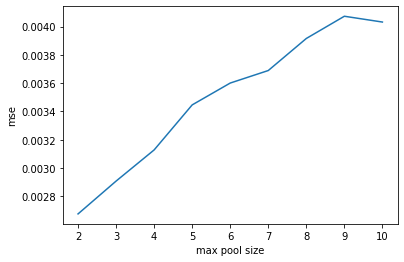

In [206]:
plt.plot(max_pool_size,max_pool_mse);
plt.xlabel('max pool size');
plt.ylabel('mse');

**We could see that increasing the pooling size does not help the prediction**

In [207]:
mse["deep CNN max"] = min(max_pool_mse)
mse

,lin_mse,sgd_reg,poly_reg,ridge_reg,lasso_reg,elastic_net,sp_rnn,dp_rnn,deepRNN-BN-DO,deepRNN_dense_each,deepLSTM_dense_each,simple mlp,deep mlp,simple CNN,deep CNN,deep CNN ave,deep CNN max
0,0.002271,0.002189,0.022761,0.002191,0.002189,0.00219,0.014262,0.003489,0.00342,0.00047,0.00086,0.002178,0.002666,0.002267,0.006322,0.006089,0.002677


**Next we experiment over average pooling**

In [208]:
def buildModelAvePool(size):
    model = keras.models.Sequential()
    model.add(keras.layers.BatchNormalization())
    model.add(Conv1D(filters=10, kernel_size=3, activation='relu', input_shape=(36,feature)))
    model.add(AveragePooling1D(pool_size=size))
    model.add(Flatten())
    for layer in range(nLayer):
        model.add(keras.layers.Dense(nNeuron,activation = 'selu',kernel_initializer="lecun_normal"))
    model.add(keras.layers.Dense(1, kernel_initializer="glorot_uniform"))
    model.compile(loss="mse", optimizer='nadam')
    return model

In [209]:
ave_pool_mse = []
ave_pool_size = [2,3,4,5,6,7,8,9,10]
for size in max_pool_size:
    checkpoint_cb = keras.callbacks.ModelCheckpoint('CNN',save_best_only=True)
    run = model.fit(X_train_3D,y_train,epochs = 30, validation_data=(X_valid_3D,y_valid),callbacks=[checkpoint_cb,])
    CNN_best = keras.models.load_model('CNN')
    y_test_predict = CNN_best.predict(X_test_3D,verbose = 0)
    ave_pool_mse.append(mean_squared_error(y_test, y_test_predict))

Epoch 1/30
36/40 [==========================>...] - ETA: 0s - loss: 2.5646e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 12ms/step - loss: 2.5532e-04 - val_loss: 0.0029
Epoch 2/30
40/40 [==============================] - 0s 2ms/step - loss: 2.4005e-04 - val_loss: 0.0033
Epoch 3/30
40/40 [==============================] - 0s 2ms/step - loss: 2.4393e-04 - val_loss: 0.0031
Epoch 4/30
40/40 [==============================] - 0s 2ms/step - loss: 2.3995e-04 - val_loss: 0.0031
Epoch 5/30
40/40 [==============================] - 0s 2ms/step - loss: 2.4141e-04 - val_loss: 0.0033
Epoch 6/30
40/40 [==============================] - 0s 2ms/step - loss: 2.3131e-04 - val_loss: 0.0030
Epoch 7/30
40/40 [==============================] - 0s 2ms/step - loss: 2.4838e-04 - val_loss: 0.0032
Epoch 8/30
40/40 [==============================] - 0s 2ms/step - loss: 2.9143e-04 - val_loss: 0.0030
Epoch 9/30
39/40 [============================>.] - ETA: 0s - loss: 2.4992e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 2s 53ms/step - loss: 2.4953e-04 - val_loss: 0.0029
Epoch 10/30
40/40 [==============================] - 0s 3ms/step - loss: 2.4508e-04 - val_loss: 0.0030
Epoch 11/30
40/40 [==============================] - 0s 2ms/step - loss: 2.3598e-04 - val_loss: 0.0030
Epoch 12/30
40/40 [==============================] - 0s 2ms/step - loss: 2.4396e-04 - val_loss: 0.0030
Epoch 13/30
40/40 [==============================] - 0s 2ms/step - loss: 2.4015e-04 - val_loss: 0.0031
Epoch 14/30
40/40 [==============================] - 0s 2ms/step - loss: 2.4564e-04 - val_loss: 0.0032
Epoch 15/30
40/40 [==============================] - 0s 3ms/step - loss: 2.3870e-04 - val_loss: 0.0034
Epoch 16/30
25/40 [=================>............] - ETA: 0s - loss: 2.1418e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 2s 43ms/step - loss: 2.2894e-04 - val_loss: 0.0028
Epoch 17/30
40/40 [==============================] - 0s 2ms/step - loss: 2.3041e-04 - val_loss: 0.0031
Epoch 18/30
40/40 [==============================] - 0s 2ms/step - loss: 2.7284e-04 - val_loss: 0.0031
Epoch 19/30
39/40 [============================>.] - ETA: 0s - loss: 3.3494e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 3.3372e-04 - val_loss: 0.0027
Epoch 20/30
40/40 [==============================] - 0s 2ms/step - loss: 3.0312e-04 - val_loss: 0.0028
Epoch 21/30
40/40 [==============================] - 0s 3ms/step - loss: 2.5288e-04 - val_loss: 0.0030
Epoch 22/30
40/40 [==============================] - 0s 3ms/step - loss: 2.4378e-04 - val_loss: 0.0028
Epoch 23/30
40/40 [==============================] - 0s 2ms/step - loss: 2.1224e-04 - val_loss: 0.0030
Epoch 24/30
40/40 [==============================] - 0s 2ms/step - loss: 2.2910e-04 - val_loss: 0.0032
Epoch 25/30
40/40 [==============================] - 0s 2ms/step - loss: 2.1349e-04 - val_loss: 0.0032
Epoch 26/30
40/40 [==============================] - 0s 2ms/step - loss: 2.1689e-04 - val_loss: 0.0032
Epoch 27/30
40/40 [==============================] - 0s 2ms/step - loss: 2.3636e-04 - val_loss: 0.0033
Epoch 28/30
40/40 [==============================] - 0s 2ms/step - loss: 2.7009e-04 

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 2.4188e-04 - val_loss: 0.0030
Epoch 2/30
40/40 [==============================] - 0s 2ms/step - loss: 2.2322e-04 - val_loss: 0.0033
Epoch 3/30
40/40 [==============================] - 0s 2ms/step - loss: 2.2239e-04 - val_loss: 0.0032
Epoch 4/30
40/40 [==============================] - 0s 2ms/step - loss: 2.3264e-04 - val_loss: 0.0032
Epoch 5/30
40/40 [==============================] - 0s 2ms/step - loss: 2.3816e-04 - val_loss: 0.0033
Epoch 6/30
40/40 [==============================] - 0s 2ms/step - loss: 2.2056e-04 - val_loss: 0.0032
Epoch 7/30
40/40 [==============================] - 0s 2ms/step - loss: 2.7246e-04 - val_loss: 0.0031
Epoch 8/30
38/40 [===========================>..] - ETA: 0s - loss: 2.8038e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 2.8138e-04 - val_loss: 0.0030
Epoch 9/30
39/40 [============================>.] - ETA: 0s - loss: 2.3834e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 2.3773e-04 - val_loss: 0.0029
Epoch 10/30
40/40 [==============================] - 0s 2ms/step - loss: 2.1305e-04 - val_loss: 0.0030
Epoch 11/30
40/40 [==============================] - 0s 2ms/step - loss: 2.1599e-04 - val_loss: 0.0031
Epoch 12/30
40/40 [==============================] - 0s 2ms/step - loss: 2.2843e-04 - val_loss: 0.0030
Epoch 13/30
40/40 [==============================] - 0s 2ms/step - loss: 2.2242e-04 - val_loss: 0.0032
Epoch 14/30
40/40 [==============================] - 0s 2ms/step - loss: 2.2796e-04 - val_loss: 0.0033
Epoch 15/30
40/40 [==============================] - 0s 2ms/step - loss: 2.2106e-04 - val_loss: 0.0034
Epoch 16/30
35/40 [=========================>....] - ETA: 0s - loss: 2.1410e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 2.1550e-04 - val_loss: 0.0029
Epoch 17/30
40/40 [==============================] - 0s 3ms/step - loss: 2.1611e-04 - val_loss: 0.0032
Epoch 18/30
40/40 [==============================] - 0s 2ms/step - loss: 2.6443e-04 - val_loss: 0.0032
Epoch 19/30
40/40 [==============================] - ETA: 0s - loss: 3.3708e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 3.3708e-04 - val_loss: 0.0028
Epoch 20/30
40/40 [==============================] - 0s 2ms/step - loss: 2.7337e-04 - val_loss: 0.0028
Epoch 21/30
40/40 [==============================] - 0s 2ms/step - loss: 2.3296e-04 - val_loss: 0.0033
Epoch 22/30
40/40 [==============================] - 0s 2ms/step - loss: 2.3998e-04 - val_loss: 0.0029
Epoch 23/30
40/40 [==============================] - 0s 2ms/step - loss: 2.0150e-04 - val_loss: 0.0030
Epoch 24/30
40/40 [==============================] - 0s 2ms/step - loss: 2.1322e-04 - val_loss: 0.0032
Epoch 25/30
40/40 [==============================] - 0s 2ms/step - loss: 2.0273e-04 - val_loss: 0.0032
Epoch 26/30
40/40 [==============================] - 0s 2ms/step - loss: 2.0734e-04 - val_loss: 0.0033
Epoch 27/30
40/40 [==============================] - 0s 2ms/step - loss: 2.2137e-04 - val_loss: 0.0033
Epoch 28/30
40/40 [==============================] - 0s 2ms/step - loss: 2.4855e-04 

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 2.2558e-04 - val_loss: 0.0031
Epoch 2/30
40/40 [==============================] - 0s 2ms/step - loss: 2.0904e-04 - val_loss: 0.0033
Epoch 3/30
40/40 [==============================] - 0s 2ms/step - loss: 2.0217e-04 - val_loss: 0.0032
Epoch 4/30
40/40 [==============================] - 0s 2ms/step - loss: 2.0712e-04 - val_loss: 0.0033
Epoch 5/30
40/40 [==============================] - 0s 2ms/step - loss: 2.1771e-04 - val_loss: 0.0034
Epoch 6/30
40/40 [==============================] - 0s 2ms/step - loss: 2.0834e-04 - val_loss: 0.0032
Epoch 7/30
40/40 [==============================] - 0s 2ms/step - loss: 2.3354e-04 - val_loss: 0.0032
Epoch 8/30
40/40 [==============================] - 0s 2ms/step - loss: 2.4878e-04 - val_loss: 0.0032
Epoch 9/30
39/40 [============================>.] - ETA: 0s - loss: 2.2633e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 2.2569e-04 - val_loss: 0.0030
Epoch 10/30
40/40 [==============================] - 0s 2ms/step - loss: 2.0688e-04 - val_loss: 0.0031
Epoch 11/30
40/40 [==============================] - 0s 2ms/step - loss: 2.0744e-04 - val_loss: 0.0032
Epoch 12/30
40/40 [==============================] - 0s 2ms/step - loss: 2.4187e-04 - val_loss: 0.0031
Epoch 13/30
40/40 [==============================] - 0s 2ms/step - loss: 2.2565e-04 - val_loss: 0.0032
Epoch 14/30
40/40 [==============================] - 0s 2ms/step - loss: 2.2075e-04 - val_loss: 0.0034
Epoch 15/30
40/40 [==============================] - 0s 2ms/step - loss: 2.1160e-04 - val_loss: 0.0035
Epoch 16/30
 1/40 [..............................] - ETA: 0s - loss: 1.6778e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 2.0684e-04 - val_loss: 0.0030
Epoch 17/30
40/40 [==============================] - 0s 2ms/step - loss: 2.1830e-04 - val_loss: 0.0033
Epoch 18/30
40/40 [==============================] - 0s 2ms/step - loss: 2.4734e-04 - val_loss: 0.0031
Epoch 19/30
39/40 [============================>.] - ETA: 0s - loss: 3.0760e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 3.0689e-04 - val_loss: 0.0029
Epoch 20/30
40/40 [==============================] - 0s 2ms/step - loss: 2.9366e-04 - val_loss: 0.0029
Epoch 21/30
40/40 [==============================] - 0s 2ms/step - loss: 2.4267e-04 - val_loss: 0.0033
Epoch 22/30
40/40 [==============================] - 0s 2ms/step - loss: 2.3029e-04 - val_loss: 0.0029
Epoch 23/30
40/40 [==============================] - 0s 2ms/step - loss: 1.8923e-04 - val_loss: 0.0032
Epoch 24/30
40/40 [==============================] - 0s 2ms/step - loss: 2.0517e-04 - val_loss: 0.0033
Epoch 25/30
40/40 [==============================] - 0s 2ms/step - loss: 1.9131e-04 - val_loss: 0.0032
Epoch 26/30
40/40 [==============================] - 0s 2ms/step - loss: 1.9773e-04 - val_loss: 0.0033
Epoch 27/30
40/40 [==============================] - 0s 2ms/step - loss: 2.0665e-04 - val_loss: 0.0033
Epoch 28/30
40/40 [==============================] - 0s 2ms/step - loss: 2.2726e-04 

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 13ms/step - loss: 2.0293e-04 - val_loss: 0.0031
Epoch 2/30
40/40 [==============================] - 0s 2ms/step - loss: 1.9562e-04 - val_loss: 0.0035
Epoch 3/30
40/40 [==============================] - 0s 2ms/step - loss: 1.8903e-04 - val_loss: 0.0033
Epoch 4/30
40/40 [==============================] - 0s 2ms/step - loss: 1.9009e-04 - val_loss: 0.0034
Epoch 5/30
40/40 [==============================] - 0s 3ms/step - loss: 2.0252e-04 - val_loss: 0.0034
Epoch 6/30
40/40 [==============================] - 0s 2ms/step - loss: 2.0305e-04 - val_loss: 0.0034
Epoch 7/30
40/40 [==============================] - 0s 2ms/step - loss: 2.2101e-04 - val_loss: 0.0032
Epoch 8/30
40/40 [==============================] - 0s 2ms/step - loss: 2.2600e-04 - val_loss: 0.0033
Epoch 9/30
40/40 [==============================] - 0s 2ms/step - loss: 2.1070e-04 - val_loss: 0.0032
Epoch 10/30
40/40 [==============================] - 0s 2ms/step - loss: 2.0156e-04 - val_lo

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 3.1387e-04 - val_loss: 0.0030
Epoch 20/30
40/40 [==============================] - 0s 3ms/step - loss: 2.9462e-04 - val_loss: 0.0030
Epoch 21/30
40/40 [==============================] - 0s 2ms/step - loss: 2.4595e-04 - val_loss: 0.0034
Epoch 22/30
40/40 [==============================] - 0s 2ms/step - loss: 2.2533e-04 - val_loss: 0.0030
Epoch 23/30
40/40 [==============================] - 0s 2ms/step - loss: 1.8093e-04 - val_loss: 0.0033
Epoch 24/30
40/40 [==============================] - 0s 2ms/step - loss: 1.9385e-04 - val_loss: 0.0034
Epoch 25/30
40/40 [==============================] - 0s 2ms/step - loss: 1.8016e-04 - val_loss: 0.0033
Epoch 26/30
40/40 [==============================] - 0s 2ms/step - loss: 1.8764e-04 - val_loss: 0.0034
Epoch 27/30
40/40 [==============================] - 0s 2ms/step - loss: 1.9763e-04 - val_loss: 0.0034
Epoch 28/30
40/40 [==============================] - 0s 2ms/step - loss: 2.1820e-04 

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 14ms/step - loss: 1.9064e-04 - val_loss: 0.0032
Epoch 2/30
40/40 [==============================] - 0s 2ms/step - loss: 1.8786e-04 - val_loss: 0.0037
Epoch 3/30
40/40 [==============================] - 0s 2ms/step - loss: 1.7934e-04 - val_loss: 0.0034
Epoch 4/30
40/40 [==============================] - 0s 3ms/step - loss: 1.8123e-04 - val_loss: 0.0035
Epoch 5/30
40/40 [==============================] - 0s 3ms/step - loss: 1.9425e-04 - val_loss: 0.0036
Epoch 6/30
40/40 [==============================] - 0s 3ms/step - loss: 1.9663e-04 - val_loss: 0.0035
Epoch 7/30
40/40 [==============================] - 0s 3ms/step - loss: 2.1350e-04 - val_loss: 0.0033
Epoch 8/30
40/40 [==============================] - 0s 2ms/step - loss: 2.3169e-04 - val_loss: 0.0034
Epoch 9/30
35/40 [=========================>....] - ETA: 0s - loss: 2.0222e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 13ms/step - loss: 2.0542e-04 - val_loss: 0.0032
Epoch 10/30
40/40 [==============================] - 0s 3ms/step - loss: 1.9282e-04 - val_loss: 0.0033
Epoch 11/30
40/40 [==============================] - 0s 2ms/step - loss: 1.9232e-04 - val_loss: 0.0035
Epoch 12/30
40/40 [==============================] - 0s 2ms/step - loss: 2.2722e-04 - val_loss: 0.0034
Epoch 13/30
40/40 [==============================] - 0s 3ms/step - loss: 2.0406e-04 - val_loss: 0.0034
Epoch 14/30
40/40 [==============================] - 0s 3ms/step - loss: 1.8950e-04 - val_loss: 0.0035
Epoch 15/30
40/40 [==============================] - 0s 3ms/step - loss: 1.9072e-04 - val_loss: 0.0037
Epoch 16/30
40/40 [==============================] - 0s 3ms/step - loss: 1.8738e-04 - val_loss: 0.0033
Epoch 17/30
40/40 [==============================] - 0s 2ms/step - loss: 1.9105e-04 - val_loss: 0.0036
Epoch 18/30
40/40 [==============================] - 0s 3ms/step - loss: 2.2548e-04 

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 2.9829e-04 - val_loss: 0.0031
Epoch 20/30
40/40 [==============================] - 0s 2ms/step - loss: 2.8209e-04 - val_loss: 0.0031
Epoch 21/30
40/40 [==============================] - 0s 2ms/step - loss: 2.3840e-04 - val_loss: 0.0034
Epoch 22/30
40/40 [==============================] - 0s 2ms/step - loss: 2.1410e-04 - val_loss: 0.0031
Epoch 23/30
40/40 [==============================] - 0s 3ms/step - loss: 1.7097e-04 - val_loss: 0.0034
Epoch 24/30
40/40 [==============================] - 0s 3ms/step - loss: 1.8246e-04 - val_loss: 0.0035
Epoch 25/30
40/40 [==============================] - 0s 2ms/step - loss: 1.7292e-04 - val_loss: 0.0035
Epoch 26/30
40/40 [==============================] - 0s 2ms/step - loss: 1.8793e-04 - val_loss: 0.0035
Epoch 27/30
40/40 [==============================] - 0s 2ms/step - loss: 1.8790e-04 - val_loss: 0.0035
Epoch 28/30
40/40 [==============================] - 0s 2ms/step - loss: 2.0942e-04 

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 1.8436e-04 - val_loss: 0.0033
Epoch 2/30
40/40 [==============================] - 0s 2ms/step - loss: 1.8524e-04 - val_loss: 0.0038
Epoch 3/30
40/40 [==============================] - 0s 2ms/step - loss: 1.7366e-04 - val_loss: 0.0035
Epoch 4/30
40/40 [==============================] - 0s 2ms/step - loss: 1.8600e-04 - val_loss: 0.0036
Epoch 5/30
40/40 [==============================] - 0s 3ms/step - loss: 1.8726e-04 - val_loss: 0.0039
Epoch 6/30
40/40 [==============================] - 0s 3ms/step - loss: 1.8622e-04 - val_loss: 0.0035
Epoch 7/30
40/40 [==============================] - 0s 3ms/step - loss: 1.9941e-04 - val_loss: 0.0034
Epoch 8/30
40/40 [==============================] - 0s 3ms/step - loss: 2.2111e-04 - val_loss: 0.0035
Epoch 9/30
35/40 [=========================>....] - ETA: 0s - loss: 1.9244e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 1.9532e-04 - val_loss: 0.0032
Epoch 10/30
40/40 [==============================] - 0s 2ms/step - loss: 1.7930e-04 - val_loss: 0.0033
Epoch 11/30
40/40 [==============================] - 0s 2ms/step - loss: 1.7881e-04 - val_loss: 0.0036
Epoch 12/30
40/40 [==============================] - 0s 2ms/step - loss: 2.1982e-04 - val_loss: 0.0035
Epoch 13/30
40/40 [==============================] - 0s 2ms/step - loss: 1.9936e-04 - val_loss: 0.0036
Epoch 14/30
40/40 [==============================] - 0s 2ms/step - loss: 1.8223e-04 - val_loss: 0.0038
Epoch 15/30
40/40 [==============================] - 0s 2ms/step - loss: 1.8077e-04 - val_loss: 0.0038
Epoch 16/30
40/40 [==============================] - 0s 2ms/step - loss: 1.7983e-04 - val_loss: 0.0034
Epoch 17/30
40/40 [==============================] - 0s 2ms/step - loss: 1.8610e-04 - val_loss: 0.0037
Epoch 18/30
40/40 [==============================] - 0s 2ms/step - loss: 2.1211e-04 

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 11ms/step - loss: 2.8395e-04 - val_loss: 0.0032
Epoch 20/30
40/40 [==============================] - 0s 2ms/step - loss: 2.8723e-04 - val_loss: 0.0033
Epoch 21/30
40/40 [==============================] - 0s 2ms/step - loss: 2.4843e-04 - val_loss: 0.0039
Epoch 22/30
40/40 [==============================] - 0s 3ms/step - loss: 2.3019e-04 - val_loss: 0.0032
Epoch 23/30
40/40 [==============================] - 0s 2ms/step - loss: 1.6648e-04 - val_loss: 0.0035
Epoch 24/30
40/40 [==============================] - 0s 2ms/step - loss: 1.7079e-04 - val_loss: 0.0036
Epoch 25/30
40/40 [==============================] - 0s 3ms/step - loss: 1.6535e-04 - val_loss: 0.0036
Epoch 26/30
40/40 [==============================] - 0s 3ms/step - loss: 1.7573e-04 - val_loss: 0.0037
Epoch 27/30
40/40 [==============================] - 0s 3ms/step - loss: 1.7832e-04 - val_loss: 0.0036
Epoch 28/30
40/40 [==============================] - 0s 2ms/step - loss: 1.8913e-04 

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 12ms/step - loss: 1.7719e-04 - val_loss: 0.0034
Epoch 2/30
40/40 [==============================] - 0s 2ms/step - loss: 1.7597e-04 - val_loss: 0.0039
Epoch 3/30
40/40 [==============================] - 0s 2ms/step - loss: 1.7219e-04 - val_loss: 0.0036
Epoch 4/30
40/40 [==============================] - 0s 3ms/step - loss: 1.7155e-04 - val_loss: 0.0037
Epoch 5/30
40/40 [==============================] - 0s 3ms/step - loss: 1.7820e-04 - val_loss: 0.0041
Epoch 6/30
40/40 [==============================] - 0s 3ms/step - loss: 1.8321e-04 - val_loss: 0.0038
Epoch 7/30
40/40 [==============================] - 0s 3ms/step - loss: 2.0061e-04 - val_loss: 0.0035
Epoch 8/30
40/40 [==============================] - 0s 3ms/step - loss: 2.0295e-04 - val_loss: 0.0035
Epoch 9/30
36/40 [==========================>...] - ETA: 0s - loss: 1.7904e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 12ms/step - loss: 1.8265e-04 - val_loss: 0.0034
Epoch 10/30
40/40 [==============================] - 0s 2ms/step - loss: 1.6869e-04 - val_loss: 0.0035
Epoch 11/30
40/40 [==============================] - 0s 3ms/step - loss: 1.6983e-04 - val_loss: 0.0038
Epoch 12/30
40/40 [==============================] - 0s 2ms/step - loss: 1.9659e-04 - val_loss: 0.0037
Epoch 13/30
40/40 [==============================] - 0s 3ms/step - loss: 1.8395e-04 - val_loss: 0.0037
Epoch 14/30
40/40 [==============================] - 0s 2ms/step - loss: 1.7346e-04 - val_loss: 0.0040
Epoch 15/30
40/40 [==============================] - 0s 2ms/step - loss: 1.7724e-04 - val_loss: 0.0039
Epoch 16/30
40/40 [==============================] - 0s 2ms/step - loss: 1.7465e-04 - val_loss: 0.0037
Epoch 17/30
40/40 [==============================] - 0s 2ms/step - loss: 1.7651e-04 - val_loss: 0.0037
Epoch 18/30
40/40 [==============================] - 0s 2ms/step - loss: 2.1384e-04 

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 13ms/step - loss: 3.2779e-04 - val_loss: 0.0033
Epoch 20/30
40/40 [==============================] - 0s 3ms/step - loss: 2.9381e-04 - val_loss: 0.0034
Epoch 21/30
40/40 [==============================] - 0s 3ms/step - loss: 2.4485e-04 - val_loss: 0.0036
Epoch 22/30
40/40 [==============================] - 0s 3ms/step - loss: 2.1459e-04 - val_loss: 0.0033
Epoch 23/30
40/40 [==============================] - 0s 3ms/step - loss: 1.5924e-04 - val_loss: 0.0036
Epoch 24/30
40/40 [==============================] - 0s 3ms/step - loss: 1.6272e-04 - val_loss: 0.0038
Epoch 25/30
40/40 [==============================] - 0s 3ms/step - loss: 1.5880e-04 - val_loss: 0.0038
Epoch 26/30
40/40 [==============================] - 0s 3ms/step - loss: 1.6727e-04 - val_loss: 0.0038
Epoch 27/30
40/40 [==============================] - 0s 3ms/step - loss: 1.6595e-04 - val_loss: 0.0039
Epoch 28/30
40/40 [==============================] - 0s 2ms/step - loss: 1.7979e-04 

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 12ms/step - loss: 1.6795e-04 - val_loss: 0.0036
Epoch 2/30
40/40 [==============================] - 0s 3ms/step - loss: 1.6755e-04 - val_loss: 0.0040
Epoch 3/30
40/40 [==============================] - 0s 3ms/step - loss: 1.6681e-04 - val_loss: 0.0037
Epoch 4/30
40/40 [==============================] - 0s 3ms/step - loss: 1.6265e-04 - val_loss: 0.0039
Epoch 5/30
40/40 [==============================] - 0s 3ms/step - loss: 1.8114e-04 - val_loss: 0.0043
Epoch 6/30
40/40 [==============================] - 0s 3ms/step - loss: 1.7991e-04 - val_loss: 0.0039
Epoch 7/30
40/40 [==============================] - 0s 3ms/step - loss: 2.0611e-04 - val_loss: 0.0038
Epoch 8/30
40/40 [==============================] - 0s 4ms/step - loss: 2.1036e-04 - val_loss: 0.0037
Epoch 9/30
40/40 [==============================] - ETA: 0s - loss: 1.7514e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 14ms/step - loss: 1.7514e-04 - val_loss: 0.0035
Epoch 10/30
40/40 [==============================] - 0s 2ms/step - loss: 1.7244e-04 - val_loss: 0.0035
Epoch 11/30
40/40 [==============================] - 0s 3ms/step - loss: 1.7051e-04 - val_loss: 0.0040
Epoch 12/30
40/40 [==============================] - 0s 3ms/step - loss: 1.8012e-04 - val_loss: 0.0038
Epoch 13/30
40/40 [==============================] - 0s 3ms/step - loss: 1.6847e-04 - val_loss: 0.0039
Epoch 14/30
40/40 [==============================] - 0s 3ms/step - loss: 1.6387e-04 - val_loss: 0.0041
Epoch 15/30
40/40 [==============================] - 0s 3ms/step - loss: 1.6570e-04 - val_loss: 0.0040
Epoch 16/30
40/40 [==============================] - 0s 3ms/step - loss: 1.6002e-04 - val_loss: 0.0039
Epoch 17/30
40/40 [==============================] - 0s 3ms/step - loss: 1.6121e-04 - val_loss: 0.0039
Epoch 18/30
40/40 [==============================] - 0s 3ms/step - loss: 1.9611e-04 

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 13ms/step - loss: 1.6053e-04 - val_loss: 0.0039
Epoch 2/30
40/40 [==============================] - 0s 2ms/step - loss: 1.5792e-04 - val_loss: 0.0043
Epoch 3/30
28/40 [====================>.........] - ETA: 0s - loss: 1.6488e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 13ms/step - loss: 1.5296e-04 - val_loss: 0.0039
Epoch 4/30
40/40 [==============================] - 0s 3ms/step - loss: 1.6009e-04 - val_loss: 0.0041
Epoch 5/30
40/40 [==============================] - 0s 4ms/step - loss: 1.8094e-04 - val_loss: 0.0045
Epoch 6/30
40/40 [==============================] - 0s 3ms/step - loss: 1.7362e-04 - val_loss: 0.0040
Epoch 7/30
40/40 [==============================] - 0s 3ms/step - loss: 1.9620e-04 - val_loss: 0.0039
Epoch 8/30
28/40 [====================>.........] - ETA: 0s - loss: 2.3231e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 0s 12ms/step - loss: 2.1449e-04 - val_loss: 0.0038
Epoch 9/30
25/40 [=================>............] - ETA: 0s - loss: 1.6208e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 15ms/step - loss: 1.7595e-04 - val_loss: 0.0036
Epoch 10/30
26/40 [==================>...........] - ETA: 0s - loss: 1.8222e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 15ms/step - loss: 1.8824e-04 - val_loss: 0.0036
Epoch 11/30
40/40 [==============================] - 0s 3ms/step - loss: 1.6723e-04 - val_loss: 0.0040
Epoch 12/30
40/40 [==============================] - 0s 3ms/step - loss: 1.6720e-04 - val_loss: 0.0038
Epoch 13/30
40/40 [==============================] - 0s 3ms/step - loss: 1.5883e-04 - val_loss: 0.0040
Epoch 14/30
40/40 [==============================] - 0s 3ms/step - loss: 1.6666e-04 - val_loss: 0.0042
Epoch 15/30
40/40 [==============================] - 0s 2ms/step - loss: 1.5965e-04 - val_loss: 0.0043
Epoch 16/30
40/40 [==============================] - 0s 2ms/step - loss: 1.6224e-04 - val_loss: 0.0040
Epoch 17/30
40/40 [==============================] - 0s 3ms/step - loss: 1.6322e-04 - val_loss: 0.0040
Epoch 18/30
40/40 [==============================] - 0s 3ms/step - loss: 1.7980e-04 - val_loss: 0.0041
Epoch 19/30
40/40 [==============================] - 0s 3ms/step - loss: 2.4129e-04 

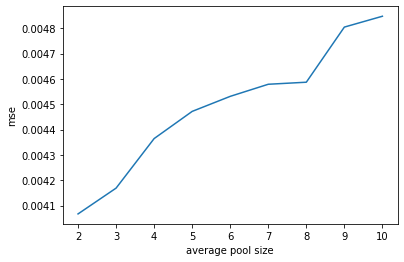

In [210]:
plt.plot(ave_pool_size,ave_pool_mse);
plt.xlabel('average pool size');
plt.ylabel('mse');

**Still, increasing the pooling size does not help.**

In [211]:
mse["deep CNN ave"] = min(ave_pool_mse)
mse

,lin_mse,sgd_reg,poly_reg,ridge_reg,lasso_reg,elastic_net,sp_rnn,dp_rnn,deepRNN-BN-DO,deepRNN_dense_each,deepLSTM_dense_each,simple mlp,deep mlp,simple CNN,deep CNN,deep CNN ave,deep CNN max
0,0.002271,0.002189,0.022761,0.002191,0.002189,0.00219,0.014262,0.003489,0.00342,0.00047,0.00086,0.002178,0.002666,0.002267,0.006322,0.004067,0.002677


**From the experiments above,we found increasing the pooling size does not help the prediction and max pooling works better than average pooling**

**Now, just for fun, we would like to see whether adding more convolution layers and pooling layers will help using average pooling with pool_size = 2**

In [212]:
model = keras.models.Sequential()
model.add(keras.layers.BatchNormalization())
model.add(Conv1D(filters=10, kernel_size=3, activation='relu', input_shape=(36,
feature)))
model.add(AveragePooling1D(pool_size=2))
model.add(Conv1D(filters=10, kernel_size=3, activation='relu', input_shape=(36,
feature)))
model.add(AveragePooling1D(pool_size=10))
model.add(Flatten())
for layer in range(nLayer):
    model.add(keras.layers.Dense(nNeuron,activation = 'selu',kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(1, kernel_initializer="glorot_uniform"))
model.compile(loss="mse", optimizer='nadam')
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer,loss = 'mean_squared_error')

In [213]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('CNN',save_best_only=True)
run = model.fit(X_train_3D,y_train,epochs = 30, validation_data=(X_valid_3D,y_valid),callbacks=[checkpoint_cb,])

Epoch 1/30
17/40 [===========>..................] - ETA: 0s - loss: 0.0084 

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 2s 22ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 2/30
29/40 [====================>.........] - ETA: 0s - loss: 0.0016

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 0.0043
Epoch 3/30
 1/40 [..............................] - ETA: 0s - loss: 9.1907e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 18ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 4/30
32/40 [=======================>......] - ETA: 0s - loss: 0.0014

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 21ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 5/30
39/40 [============================>.] - ETA: 0s - loss: 0.0013    

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 17ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 6/30
 1/40 [..............................] - ETA: 0s - loss: 7.1614e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 17ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 7/30
31/40 [======================>.......] - ETA: 0s - loss: 0.0012

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 20ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 8/30
35/40 [=========================>....] - ETA: 0s - loss: 0.0012

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 9/30
34/40 [========================>.....] - ETA: 0s - loss: 0.0012

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 10/30
 1/40 [..............................] - ETA: 0s - loss: 6.7945e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 17ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 11/30
 1/40 [..............................] - ETA: 0s - loss: 0.0011

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 29ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 12/30
 1/40 [..............................] - ETA: 0s - loss: 9.9737e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 13/30
32/40 [=======================>......] - ETA: 0s - loss: 0.0011

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 14/30
40/40 [==============================] - ETA: 0s - loss: 0.0011

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 2s 51ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 15/30
 1/40 [..............................] - ETA: 0s - loss: 7.0802e-04

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


40/40 [==============================] - 2s 53ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 16/30
40/40 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 17/30
40/40 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 18/30
40/40 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 19/30
40/40 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 20/30
40/40 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 21/30
40/40 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 22/30
40/40 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 23/30
40/40 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 24/30
40/40 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 25/30
40/40 [==

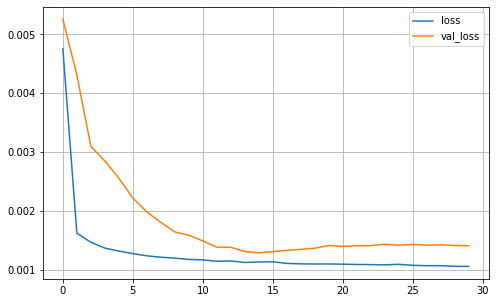

In [214]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

**The model seems no overfitting since the gap is small**

In [215]:
CNN_best = keras.models.load_model('CNN')
y_test_predict = CNN_best.predict(X_test_3D,verbose = 0)
mse["deep CNN"] = mean_squared_error(y_test, y_test_predict)
mse

,lin_mse,sgd_reg,poly_reg,ridge_reg,lasso_reg,elastic_net,sp_rnn,dp_rnn,deepRNN-BN-DO,deepRNN_dense_each,deepLSTM_dense_each,simple mlp,deep mlp,simple CNN,deep CNN,deep CNN ave,deep CNN max
0,0.002271,0.002189,0.022761,0.002191,0.002189,0.00219,0.014262,0.003489,0.00342,0.00047,0.00086,0.002178,0.002666,0.002267,0.00242,0.004067,0.002677


**We found that adding more convolution layers and pooling layers decrease the mse in the prediction.Thus, we need to put more effort to design a better network architecture for better performance**

## Conclusion

In [230]:
mse.transpose()

,0
lin_mse,0.002271
sgd_reg,0.002189
poly_reg,0.022761
ridge_reg,0.002191
lasso_reg,0.002189
elastic_net,0.002190
sp_rnn,0.014262
dp_rnn,0.003489
deepRNN-BN-DO,0.003420
deepRNN_dense_each,0.000470


**As we could see from the table above,deep LSTM with dense layer has the best performance comparing with all other models without overfitting the data, which is consistent with natural of LSTM.<br>
In addition, we found that simpler models tend to perform  better than complicated models, which is consistent with Occam'sRazor.<br>
The next step is to develop a trading strategy using the predicted daily returns of Tesla to make profit by incorrperating new data**

## Citations

**The idea of this project is originated from "Quantative Trading with Machine Learning" by Rene ́ M. Glawion, which is a course project for CS 229 in Stanford University. That project could be found from the link below. We use similar ideas where target returns is predicted using the daily returns from its supplier companies.** <br>
**Project link: https://cs229.stanford.edu/proj2021spr/report2/81953230.pdf**